In [1]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=10, roi=2500, offset=5000,gclass_num=5,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/Journal_2"
    parent_dir = "/home/rimali2009/Journal_2"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g7_j2_roi770_jogan_5500_400grid"
    file_list = ['/home/rimali2009/Journal_2/eta_5500_g7_300grid_jogan_g7_rw820_400grid.csv']
    initial_conditions = ['/home/rimali2009/Journal_2/start_param_random_5500_jogan_g7_rw820_400grid.csv']
    connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=7, topodx=10., roi=770)
    

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values ​​of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/Journal_2/data_g7_j2_roi770_jogan_5500_400grid/'
    resdir = '/home/rimali2009/Journal_2/result_g7_j2_roi770_jogan_5500_400grid/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [4500,5000]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)

Using TensorFlow backend.


Train on 3600 samples, validate on 900 samples
Epoch 1/2000
3600/3600 [==============================] - 3s 830us/step - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 0.0718 - val_mean_squared_error: 0.0718
Epoch 2/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 3/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0585 - mean_squared_error: 0.0585 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 4/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 5/2000
3600/3600 [==============================] - 1s 237us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 6/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0386 - mean_squared_error: 0.03

3600/3600 [==============================] - 1s 244us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 98/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 99/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 100/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 101/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 102/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0101 - val_mean_squared_error: 0.01

3600/3600 [==============================] - 1s 245us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 194/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 195/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 196/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 197/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 198/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0082 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 244us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 290/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 291/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 292/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 293/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 294/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0071 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 244us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 386/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 387/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 388/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 389/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 390/2000
3600/3600 [==============================] - 1s 246us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0063 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 244us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 482/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 483/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 484/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 485/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 486/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0063 - val_mean_squared_error: 0.

Epoch 529/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 530/2000
3600/3600 [==============================] - 1s 247us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 531/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 532/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 533/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 534/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0058 - val_mean_sq

3600/3600 [==============================] - 1s 246us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 626/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 627/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 628/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 629/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 630/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0054 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 244us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 722/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 723/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 724/2000
3600/3600 [==============================] - 1s 246us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 725/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 726/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0052 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 244us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 818/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 819/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 820/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 821/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 822/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0050 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 244us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 914/2000
3600/3600 [==============================] - 1s 247us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 915/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 916/2000
3600/3600 [==============================] - 1s 246us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 917/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 918/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0049 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 242us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1010/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1011/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1012/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1013/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1014/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0055 - val_mean_squared_erro

3600/3600 [==============================] - 1s 243us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1058/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1059/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1060/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1061/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1062/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0048 - val_mean_squared_erro

3600/3600 [==============================] - 1s 243us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1106/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1107/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1108/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1109/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1110/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0052 - val_mean_squared_erro

3600/3600 [==============================] - 1s 243us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1154/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1155/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1156/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1157/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1158/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0051 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1202/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1203/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1204/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1205/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 1206/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0048 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1250/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1251/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1252/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1253/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1254/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0048 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1298/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1299/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1300/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1301/2000
3600/3600 [==============================] - 1s 242us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1302/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_erro

3600/3600 [==============================] - 1s 243us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1346/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1347/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1348/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1349/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1350/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0051 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1394/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1395/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1396/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1397/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1398/2000
3600/3600 [==============================] - 1s 246us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0047 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1442/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1443/2000
3600/3600 [==============================] - 1s 246us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1444/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1445/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1446/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0050 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1490/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1491/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1492/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1493/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1494/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0050 - val_mean_squared_erro

3600/3600 [==============================] - 1s 243us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1538/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1539/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1540/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1541/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1542/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0045 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1586/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1587/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1588/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1589/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1590/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0049 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1634/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1635/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1636/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1637/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1638/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0045 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1682/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1683/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1684/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1685/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1686/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0044 - val_mean_squared_erro

3600/3600 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1730/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1731/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1732/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1733/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1734/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_erro

3600/3600 [==============================] - 1s 246us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1778/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1779/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1780/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1781/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1782/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0045 - val_mean_squared_erro

3600/3600 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1826/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1827/2000
3600/3600 [==============================] - 1s 246us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1828/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1829/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1830/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_erro

3600/3600 [==============================] - 1s 245us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1874/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1875/2000
3600/3600 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1876/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1877/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1878/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_erro

3600/3600 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1922/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1923/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1924/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1925/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1926/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_erro

3600/3600 [==============================] - 1s 243us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1970/2000
3600/3600 [==============================] - 1s 241us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1971/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1972/2000
3600/3600 [==============================] - 1s 243us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1973/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1974/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0046 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model
Train on 4000 samples, validate on 1000 samples
Epoch 1/2000
4000/4000 [==============================] - 1s 368us/step - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 0.0714 - val_mean_squared_error: 0.0714
Epoch 2/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 3/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 4/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 5/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 6/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0371 - mean_squ

4000/4000 [==============================] - 1s 244us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 98/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 99/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 100/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 101/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 102/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0104 - val_mean_squared_error: 0.01

4000/4000 [==============================] - 1s 244us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 194/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 195/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 196/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 197/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 198/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0081 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 245us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 290/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 291/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 292/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 293/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 294/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0068 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 245us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 386/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 387/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 388/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 389/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 390/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0065 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 244us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 482/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 483/2000
4000/4000 [==============================] - 1s 246us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 484/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 485/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 486/2000
4000/4000 [==============================] - 1s 241us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0057 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 243us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 578/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 579/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 580/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 581/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 582/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0055 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 243us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 674/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 675/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 676/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 677/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 678/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0051 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 244us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 770/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 771/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 772/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 773/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 774/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0053 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 244us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 866/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 867/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 868/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 869/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 870/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0052 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 244us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 962/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 963/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 964/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 965/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 966/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0045 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 243us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1058/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1059/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1060/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1061/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1062/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0047 - val_mean_squared_erro

4000/4000 [==============================] - 1s 244us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1106/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1107/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1108/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1109/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1110/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_erro

4000/4000 [==============================] - 1s 243us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1154/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1155/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1156/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1157/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1158/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0040 - val_mean_squared_erro

4000/4000 [==============================] - 1s 243us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1202/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1203/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1204/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1205/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1206/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0043 - val_mean_squared_erro

4000/4000 [==============================] - 1s 242us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1250/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1251/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1252/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1253/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1254/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1298/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1299/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1300/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1301/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1302/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0043 - val_mean_squared_erro

4000/4000 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1346/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1347/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1348/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1349/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1350/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0043 - val_mean_squared_erro

4000/4000 [==============================] - 1s 243us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1394/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1395/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1396/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1397/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1398/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_erro

4000/4000 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1442/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1443/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1444/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1445/2000
4000/4000 [==============================] - 1s 241us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1446/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0039 - val_mean_squared_erro

4000/4000 [==============================] - 1s 244us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1490/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1491/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1492/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1493/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1494/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0040 - val_mean_squared_erro

4000/4000 [==============================] - 1s 242us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1538/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1539/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1540/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1541/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1542/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1586/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1587/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1588/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1589/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1590/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0037 - val_mean_squared_erro

4000/4000 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1634/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1635/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1636/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1637/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1638/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0044 - val_mean_squared_erro

4000/4000 [==============================] - 1s 243us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1682/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1683/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1684/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1685/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1686/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0039 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1730/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1731/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1732/2000
4000/4000 [==============================] - 1s 242us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1733/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1734/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1778/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1779/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1780/2000
4000/4000 [==============================] - 1s 239us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1781/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1782/2000
4000/4000 [==============================] - 1s 243us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0039 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1826/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1827/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1828/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1829/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1830/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0046 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1874/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1875/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1876/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1877/2000
4000/4000 [==============================] - 1s 246us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1878/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1922/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1923/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1924/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1925/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1926/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_erro

4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1970/2000
4000/4000 [==============================] - 1s 245us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1971/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1972/2000
4000/4000 [==============================] - 1s 246us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1973/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1974/2000
4000/4000 [==============================] - 1s 244us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model


In [ ]:
from scipy.stats import variation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

hfont = {'fontname':'Century Gothic'}
textcol = 'k'

datadir = '/home/rimali2009/Journal_2/data_g7_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g7_j2_roi770_jogan_5500_400grid/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
resi = test_result - icond
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5','C_6','C_7']

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation:', np.std(resi[:,i]))
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('CV:', np.std(resi[:,i],ddof=1)/np.mean(resi[:,i]))                           
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

     distance       513       453       400       354       312       276  \
0    0.000000  0.021065  0.022898  0.017641  0.016226  0.002465  0.002237   
1  109.646182  0.015466  0.016398  0.012310  0.011210  0.001322  0.001217   
2  450.682215  0.005640  0.006018  0.004529  0.004128  0.000372  0.000340   
3  543.078703  0.010462  0.012003  0.009828  0.009243  0.001080  0.000985   
4  674.221738  0.008758  0.012232  0.011496  0.011298  0.003010  0.002508   
5  766.825235  0.003999  0.006536  0.006360  0.006313  0.002220  0.001804   
6  879.030860  0.000656  0.001052  0.001034  0.001029  0.000385  0.000312   
7  965.302169  0.002321  0.004002  0.004189  0.004239  0.002278  0.001827   

        244  
0  0.001563  
1  0.000964  
2  0.000272  
3  0.000743  
4  0.000679  
5  0.000244  
6  0.000038  
7  0.000097  
[[4.94602705e+03 6.68379519e+00 1.50139861e+00 1.21104479e-02
  1.39979613e-02 1.14476311e-02 9.75788171e-03 5.16416457e-03
  2.98375159e-03 3.12139848e-03]]


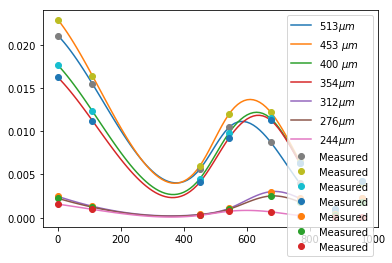

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/Journal_2/data_g7_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g7_j2_roi770_jogan_5500_400grid/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')
#gclass = 3
#gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
gclass = 7
gclass_label =  ["513${\mu}m$","453 ${\mu}m$", "400 ${\mu}m$","354${\mu}m$", "312${\mu}m$","276${\mu}m$","244${\mu}m$"]
gclass_name=['513','453','400','354','312','276','244'] 

topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data
#dist_max = 22200. #Distance of distal end of learning data
outcrop = pd.read_csv('../Journal_2/jogan_gs7_range.csv')
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
#d = pd.DataFrame(np.zeros((1, 7)),columns=['distance', 'g1','g2','g3','g4','g5','g7'])
#print(d)
#v=np.concatenate((outcrop, d))
#print(v)
#outcrop=pd.DataFrame(v,columns=['distance', 'g1','g2','g3','g4','g5','g7'])
#outcrop['distance'].iloc[-1]=4000
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    #f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="quadratic",bounds_error=False,fill_value='extrapolate')
    #f = interp1d(outcrop['distance'],np.log10(outcrop.iloc[:,j+1]), kind="cubic",bounds_error=False,fill_value='extrapolate') 
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="cubic",bounds_error=False,fill_value='extrapolate') 
    #Interpolation function of jth granularity level
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data


#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g7_g300_j2_roi770_jogan_5500_400grid.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
for i in range(gclass):
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
plt.legend()
plt.show()

<Figure size 1750x1000 with 2 Axes>

NameError: name 'read_setfile' is not defined

(5500, 9)
(5500, 2400)


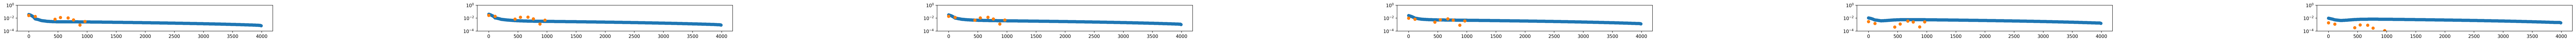

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_jogan_g7_Rw820_400grid as fmodel
import time
import ipdb
%matplotlib inline


#dist_max = 3000.
gclass = 7
topodx=10.0
#gclass_name = ['840microm','594microm','420microm','297microm','210microm','148microm']#gclass_name = ['500micron', '125micron', '63micron']
gclass_name=['513','453','400','354','312','276','244']
gname_tex = ["513${\mu}m$","453 ${\mu}m$", "400 ${\mu}m$","354${\mu}m$", "312${\mu}m$","276${\mu}m$","244${\mu}m$"]

estimated_icond=np.loadtxt('outcrop_result_g7_g300_j2_roi770_jogan_5500_400grid.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g7_400grid.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g7_j2_roi770_400grid.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g7_j2_roi770_400grid.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_thickness_5K_g7_j2_roi770_400grid.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['513','453','400','354','312','276','244'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_Distance_5K_g7_j2_roi770_400grid.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g7_j2_roi770_400grid.csv',estimated_dep_5000,delimiter=',')
#data_estim=pd.DataFrame(estimated_dep_5000,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#print(estimated_dep_5000)

#Formatting the loaded data
#estimated_dep_df = pd.DataFrame(estimated_dep,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
#estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))
#print(estimated_dep_5000)
#Read original data
outcrop = pd.read_csv('../Journal_2/jogan_gs7_range.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','513','453','400','354','312','276','244'])
#Plot
plt.figure(num=None, figsize=(100, 1), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.10, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'o', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.0001,1.0])
    #plt.xlim(-100,4000)
    plt.savefig("thickness_distance_curve_joganfinal_g7_2.png")
    


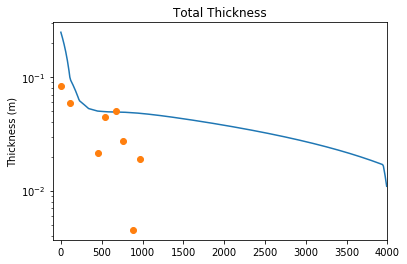

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_jogan_5gs_Rw820_400grid as fmodel
import time
import ipdb
%matplotlib inline

estimated_thick=pd.read_csv('estimated_thick.csv',delimiter=',')
estimated_thick= pd.DataFrame(estimated_thick,columns=['distance','500','420','354','297','250','thickness'])
#print(estimated_thick)
measured_thick=pd.read_csv('measured_thick.csv',delimiter=',')
measured_thick=pd.DataFrame(measured_thick,columns=['distance','thickness'])


#Plot

plt.plot(estimated_thick['distance'],estimated_thick['thickness'],'-',label='Estimated')
plt.plot(measured_thick['distance'],measured_thick['thickness'],'o',label='Measured')
plt.title('Total Thickness')
plt.ylabel('Thickness (m)')
plt.yscale("log")
plt.xlim(-100,4000)
plt.savefig('../thickness.png')
plt.savefig('../thickness.eps')
plt.show()








        

In [90]:
def plot_result(params, labels, xmin, xmax):
    
    deposit_c = []
    totalthick = []
    symbollist = ['-','-.','--',':','-','-.']
    
    #与えられたパラメーターから結果を計算する
    for j in range(len(params)):
        deposit_c.append([])
        totalthick.append([])
        (x, C, x_dep, deposit_c[j]) = fmodel.forward(params[j]) #最適解を計算
        cnum = fmodel.cnum #粒度階の数を取得
        totalthick[j] = np.sum(deposit_c[j],axis=0)
    
    #xのオフセット補正（解析では最初のデータ点の値が座標0となるようにしているため）
    x_dep = x_dep + spoints[0]
    
    
    #プロットの書式を整える
    plt.figure(num=None, figsize=(7, 8.5), dpi=150, facecolor='w', edgecolor='k')
    fp = FontProperties(size=9)
    plt.rcParams["font.size"] = 9
        
    plt.subplot(cnum+1,1,1)
    plt.plot(spoints, np.sum(deposit_o,axis=0),marker='o', markersize=4, fillstyle='none', linestyle = 'None', label = "Observation")
    for l in range(len(params)):
        plt.plot(x_dep[xmin:xmax], totalthick[l][xmin:xmax], symbollist[l], linewidth = 0.75, label = labels[l])
    plt.title('Total Thickness')
    plt.ylabel('Thickness (m)')
    plt.yscale("log")
    plt.ylim(0,0.4)
    plt.legend(prop = fp, loc='best', borderaxespad=1)




In [9]:
gclass = 6
#print(estimated_dep_5000['distance'])
for i in range(gclass):
    x = estimated_dep_5000['distance']
    y = estimated_dep_5000[gclass_name[i]]
    a=np.interp(965.302169,x,y)
    print(a)

0.002559440480031986
0.003148614269749093
0.003859663386518348
0.004673341929448533
0.005597796436650212
0.006637033891032267


     distance       513       453       400       354       312       276  \
0    0.000000  0.021065  0.022898  0.017641  0.016226  0.002465  0.002237   
1  109.646182  0.015466  0.016398  0.012310  0.011210  0.001322  0.001217   
2  450.682215  0.005640  0.006018  0.004529  0.004128  0.000372  0.000340   
3  543.078703  0.010462  0.012003  0.009828  0.009243  0.001080  0.000985   
4  674.221738  0.008758  0.012232  0.011496  0.011298  0.003010  0.002508   
5  766.825235  0.003999  0.006536  0.006360  0.006313  0.002220  0.001804   
6  879.030860  0.000656  0.001052  0.001034  0.001029  0.000385  0.000312   
7  965.302169  0.002321  0.004002  0.004189  0.004239  0.002278  0.001827   

        244  
0  0.001563  
1  0.000964  
2  0.000272  
3  0.000743  
4  0.000679  
5  0.000244  
6  0.000038  
7  0.000097  
     distance       513       453       400       354       312       276  \
0  109.646182  0.015466  0.016398  0.012310  0.011210  0.001322  0.001217   
1  450.682215  0.005640  0

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


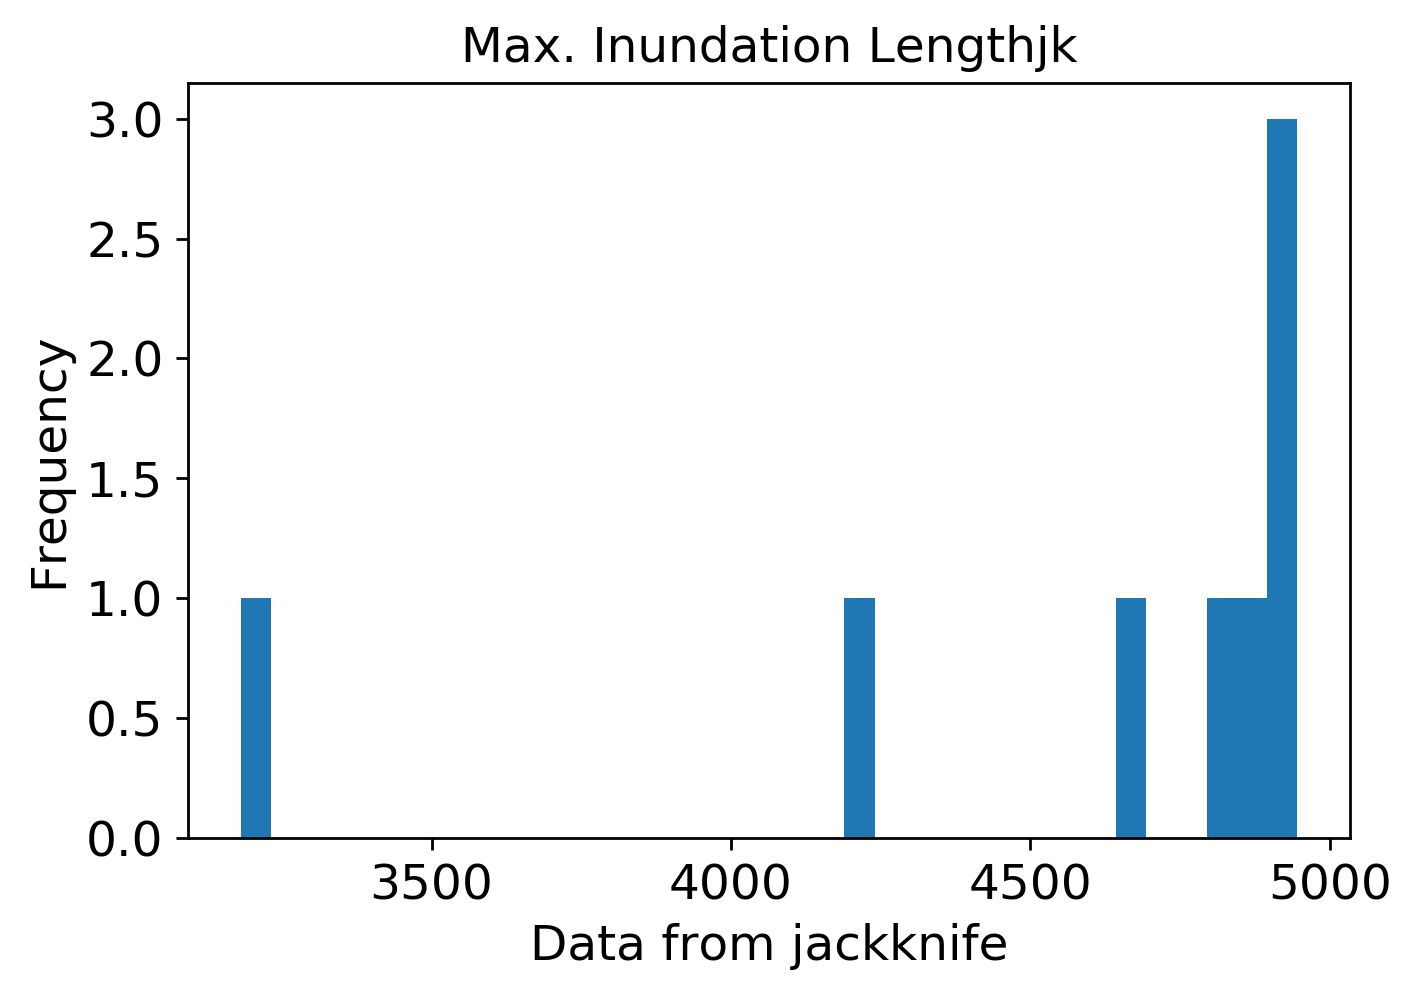

mean: 6.174533189177267
jk_e: 0.9175268890759515
CI 1.7983527025888648


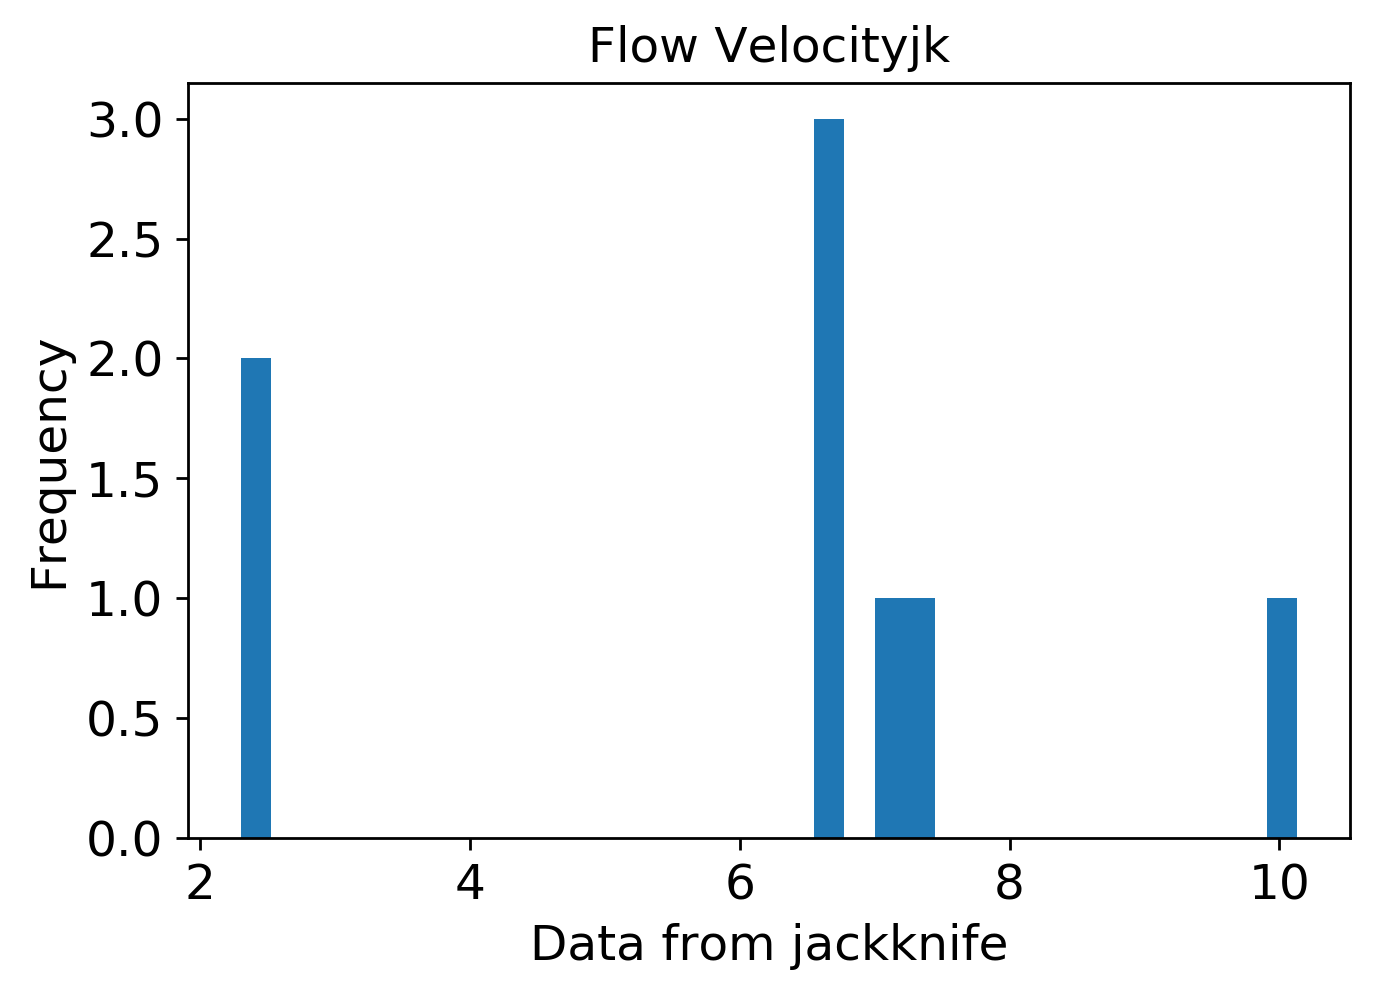

mean: 1.8367342869127066
jk_e: 0.21997917079827614
CI 0.43115917476462123


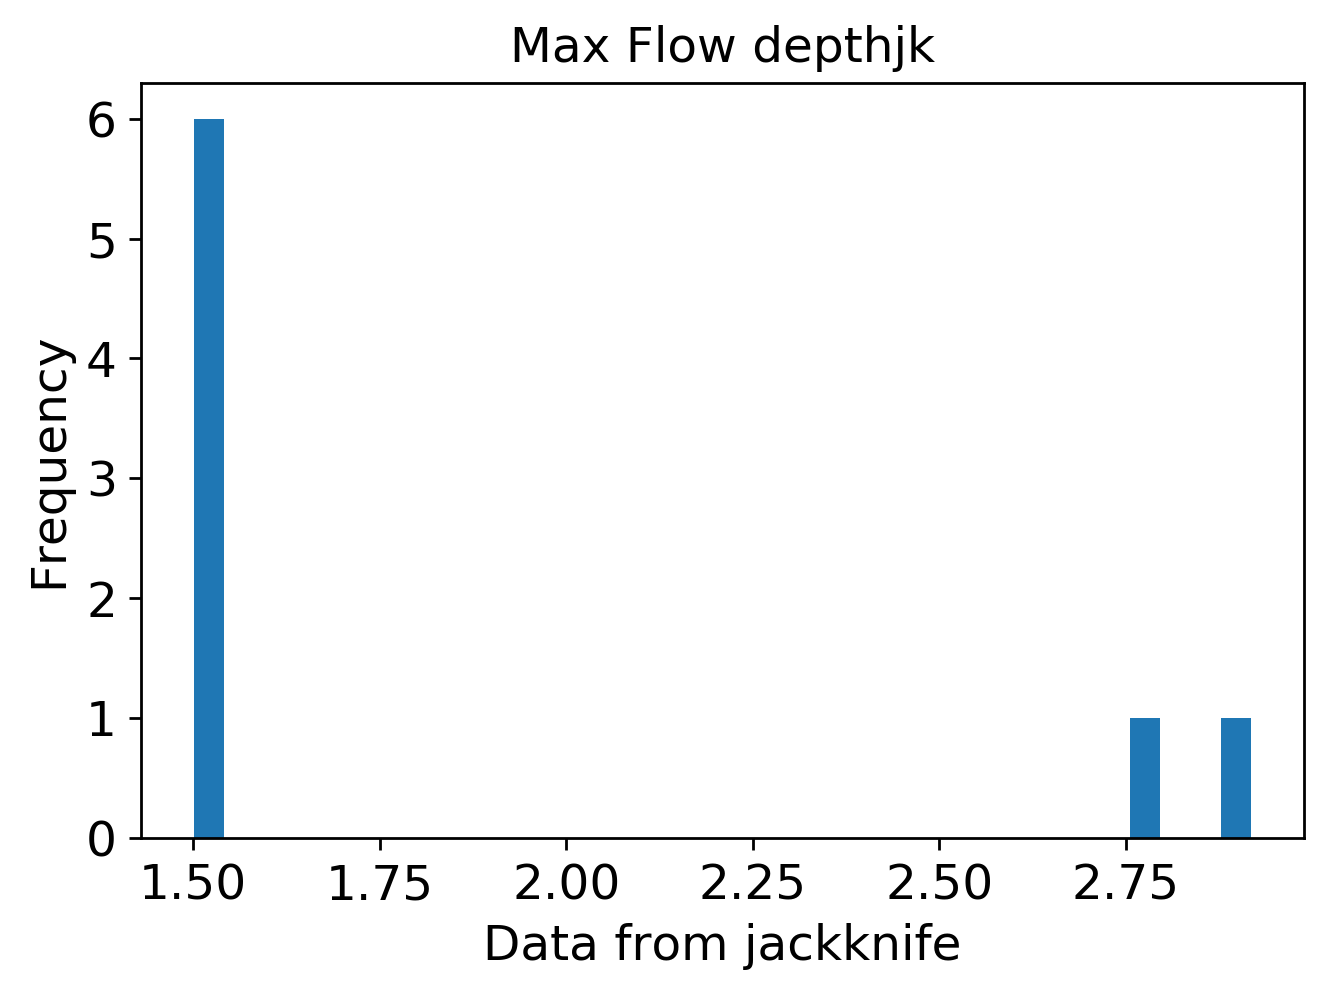

mean: 0.011491854743967968
jk_e: 0.0008686077194520923
CI 0.0017024711301261008


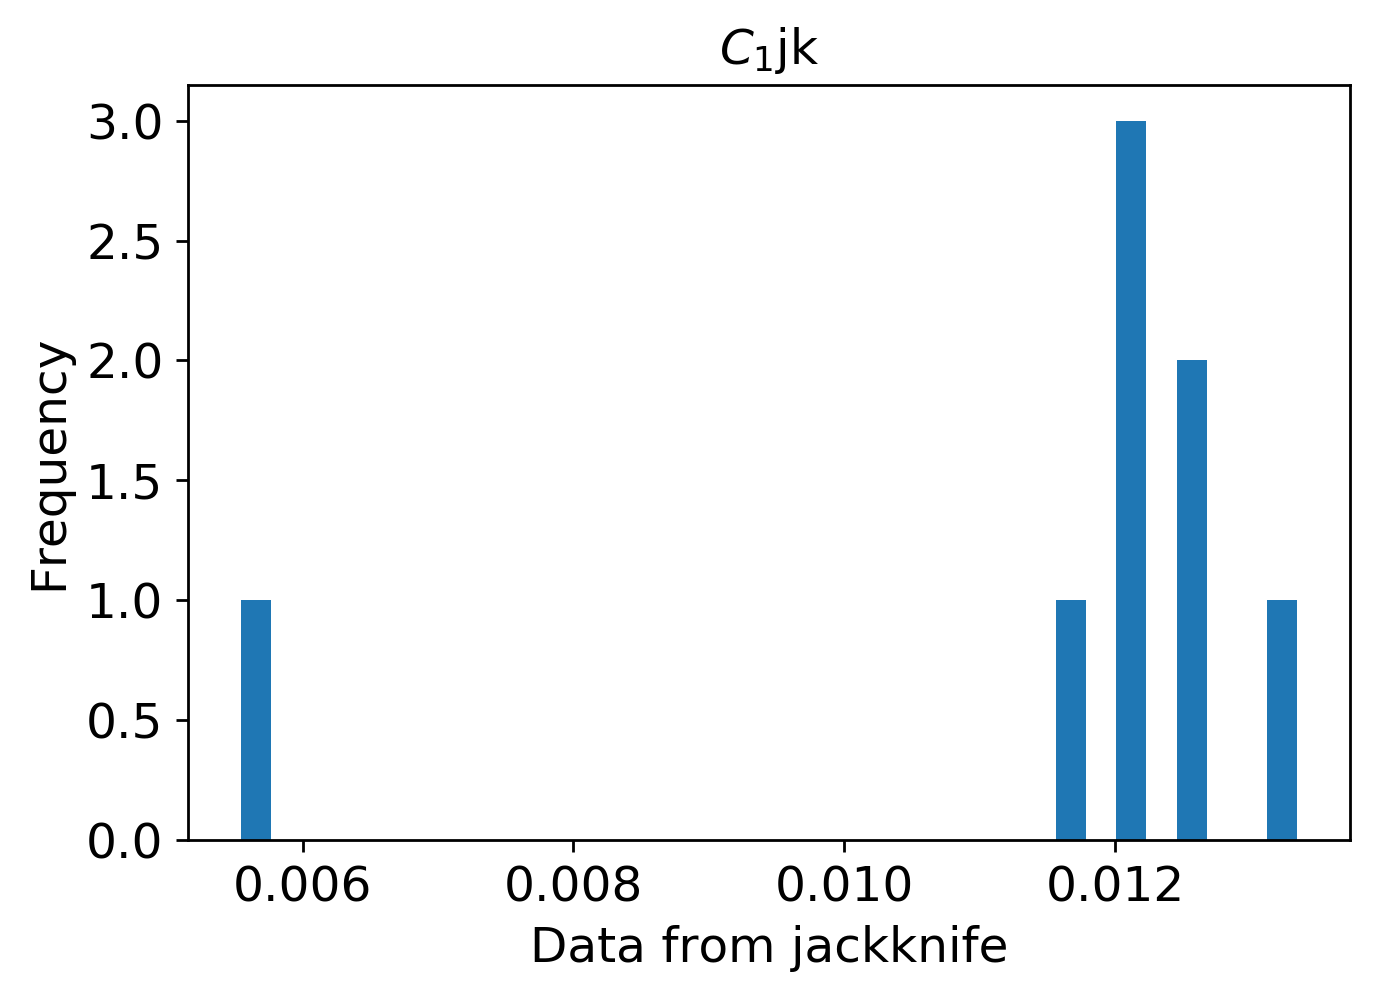

mean: 0.013099022934691014
jk_e: 0.001058119209597606
CI 0.0020739136508113078


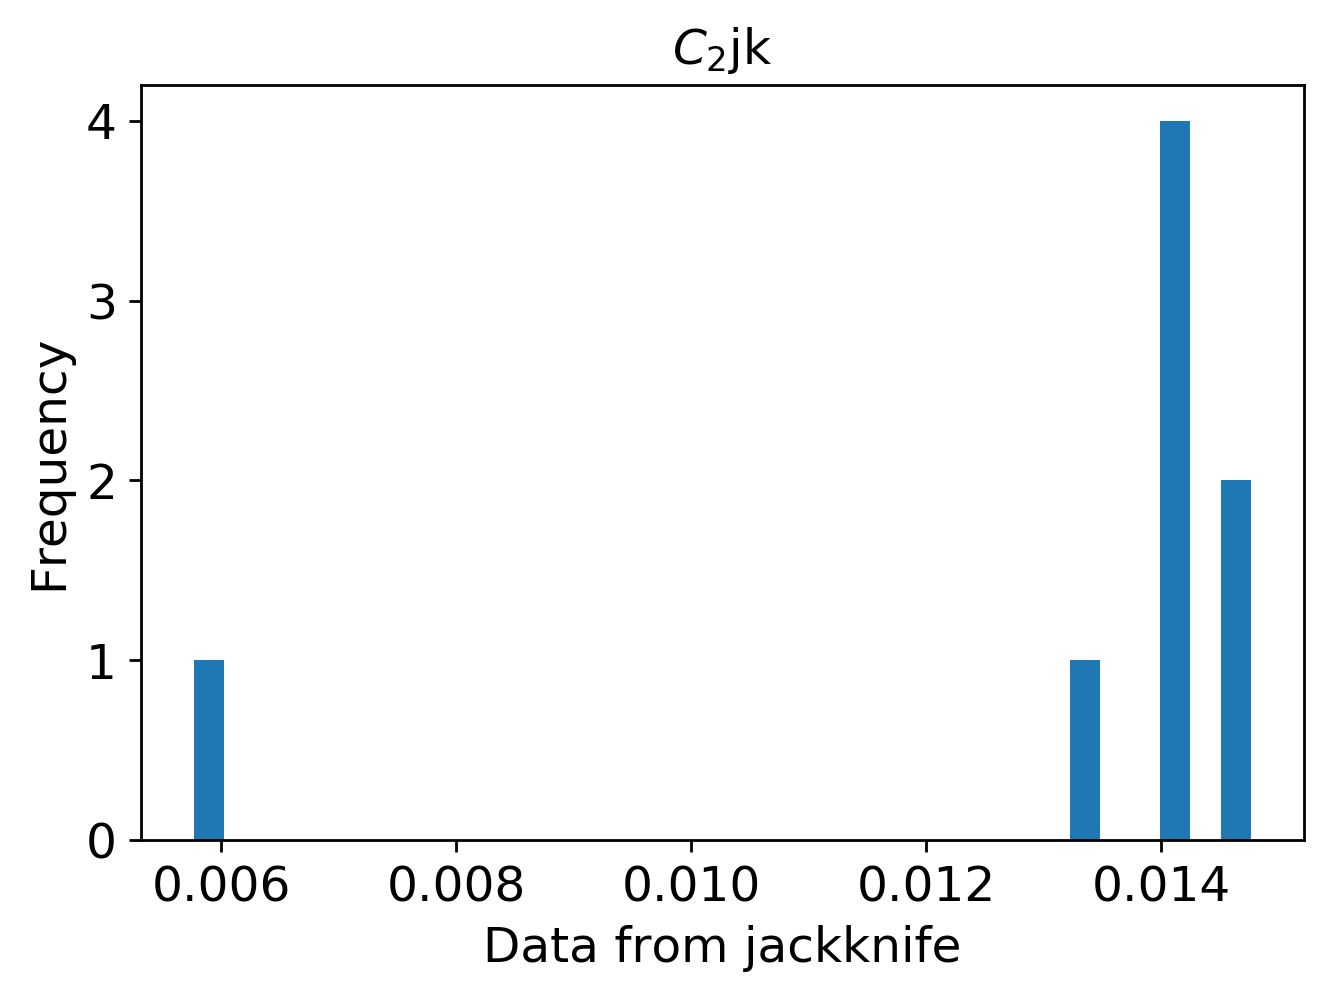

mean: 0.010647554083441452
jk_e: 0.0008252564928496605
CI 0.0016175027259853346


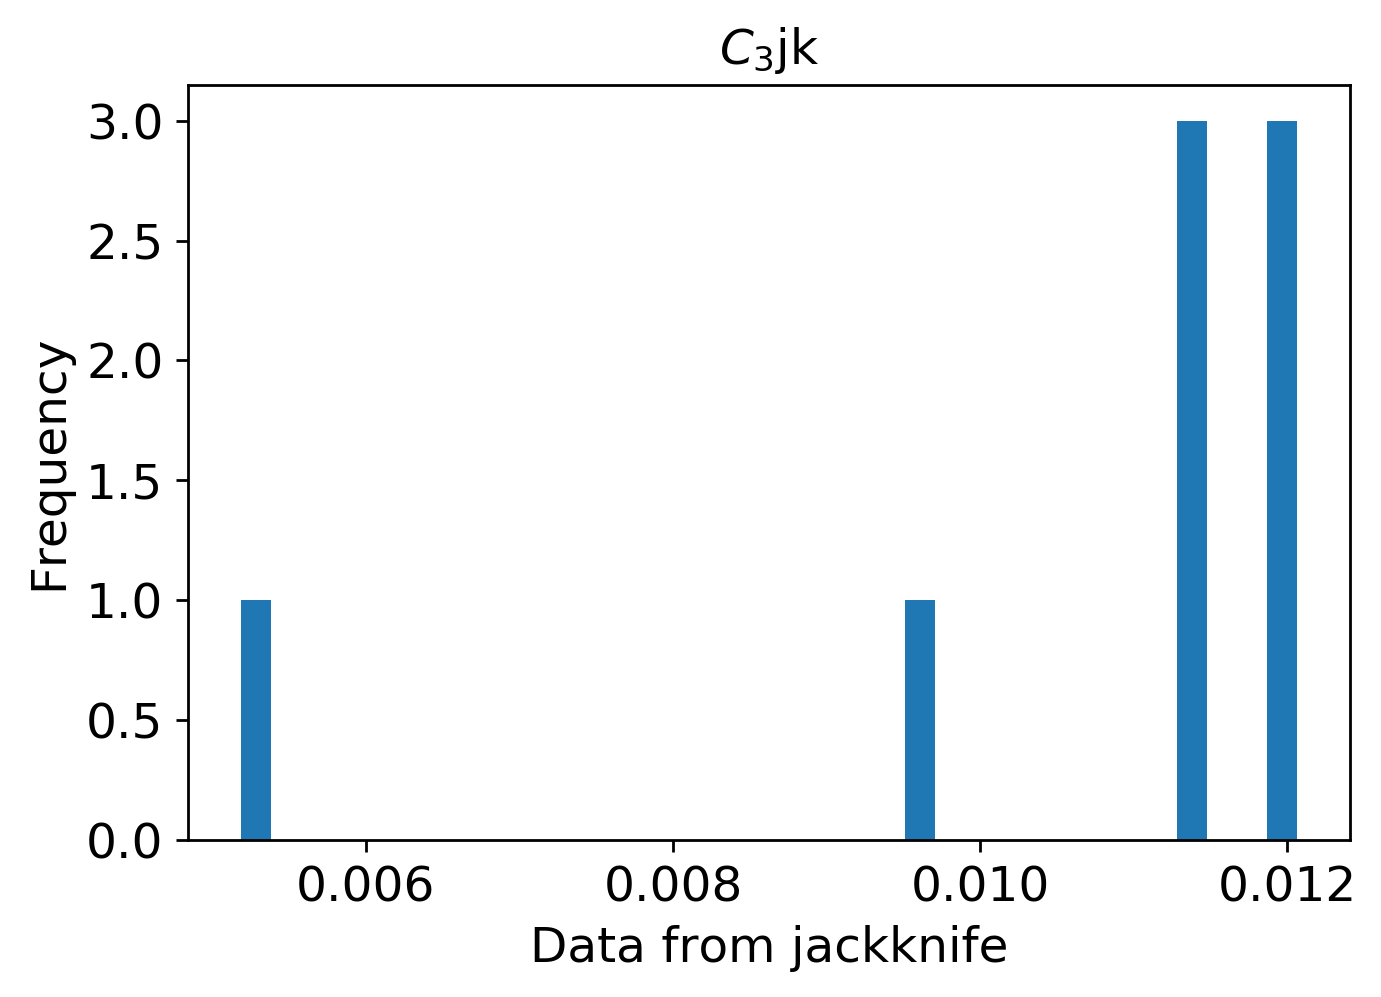

mean: 0.009186492465719438
jk_e: 0.0007404538603060458
CI 0.0014512895661998497


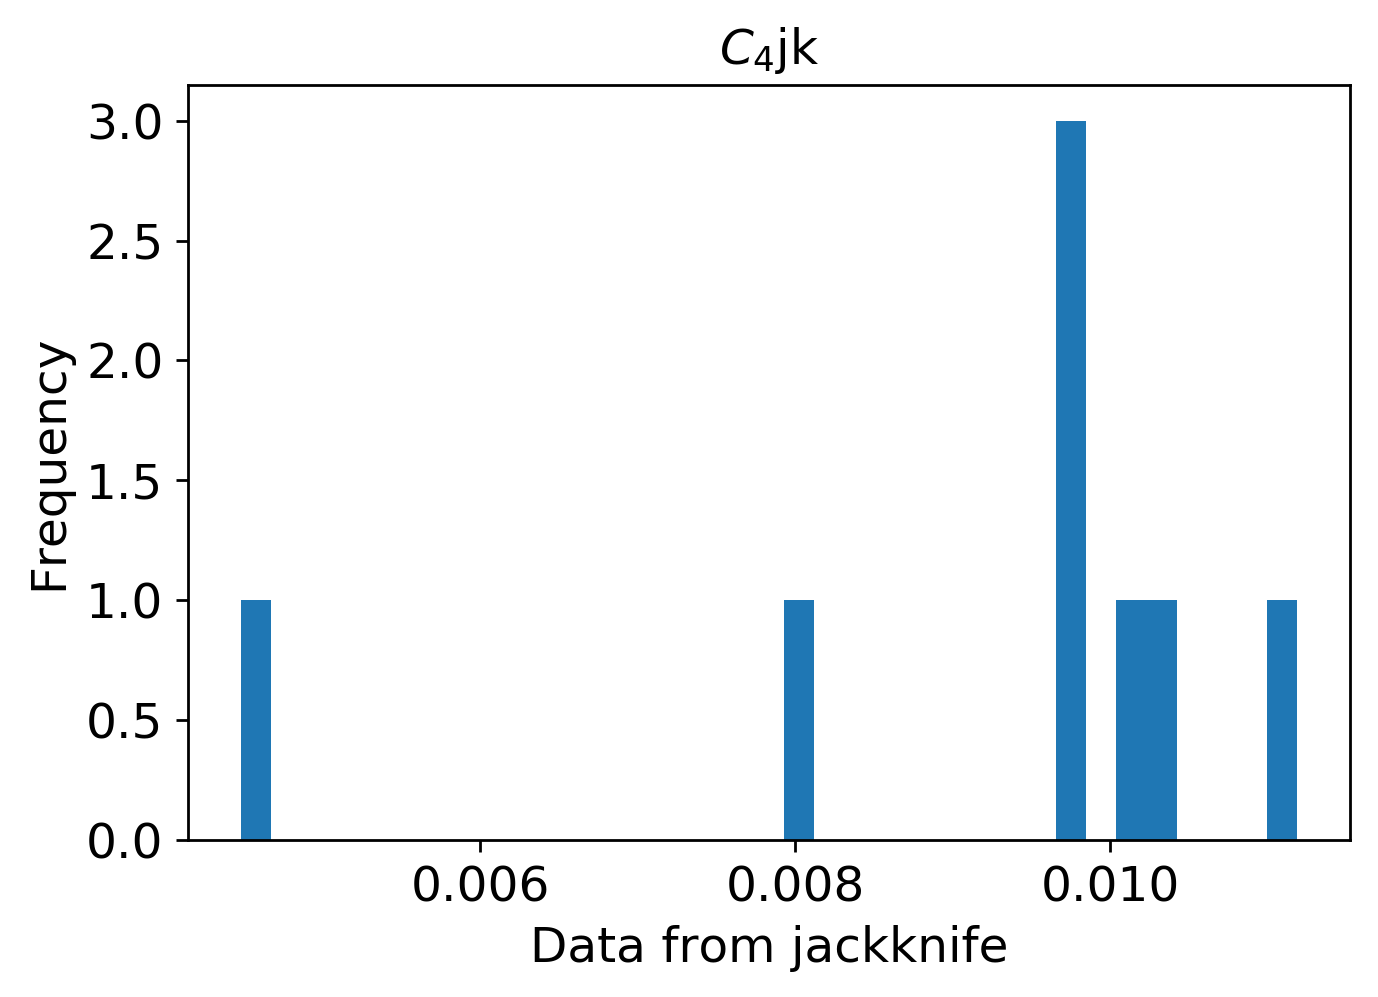

mean: 0.004423119385176259
jk_e: 0.0004210844252030194
CI 0.000825325473397918


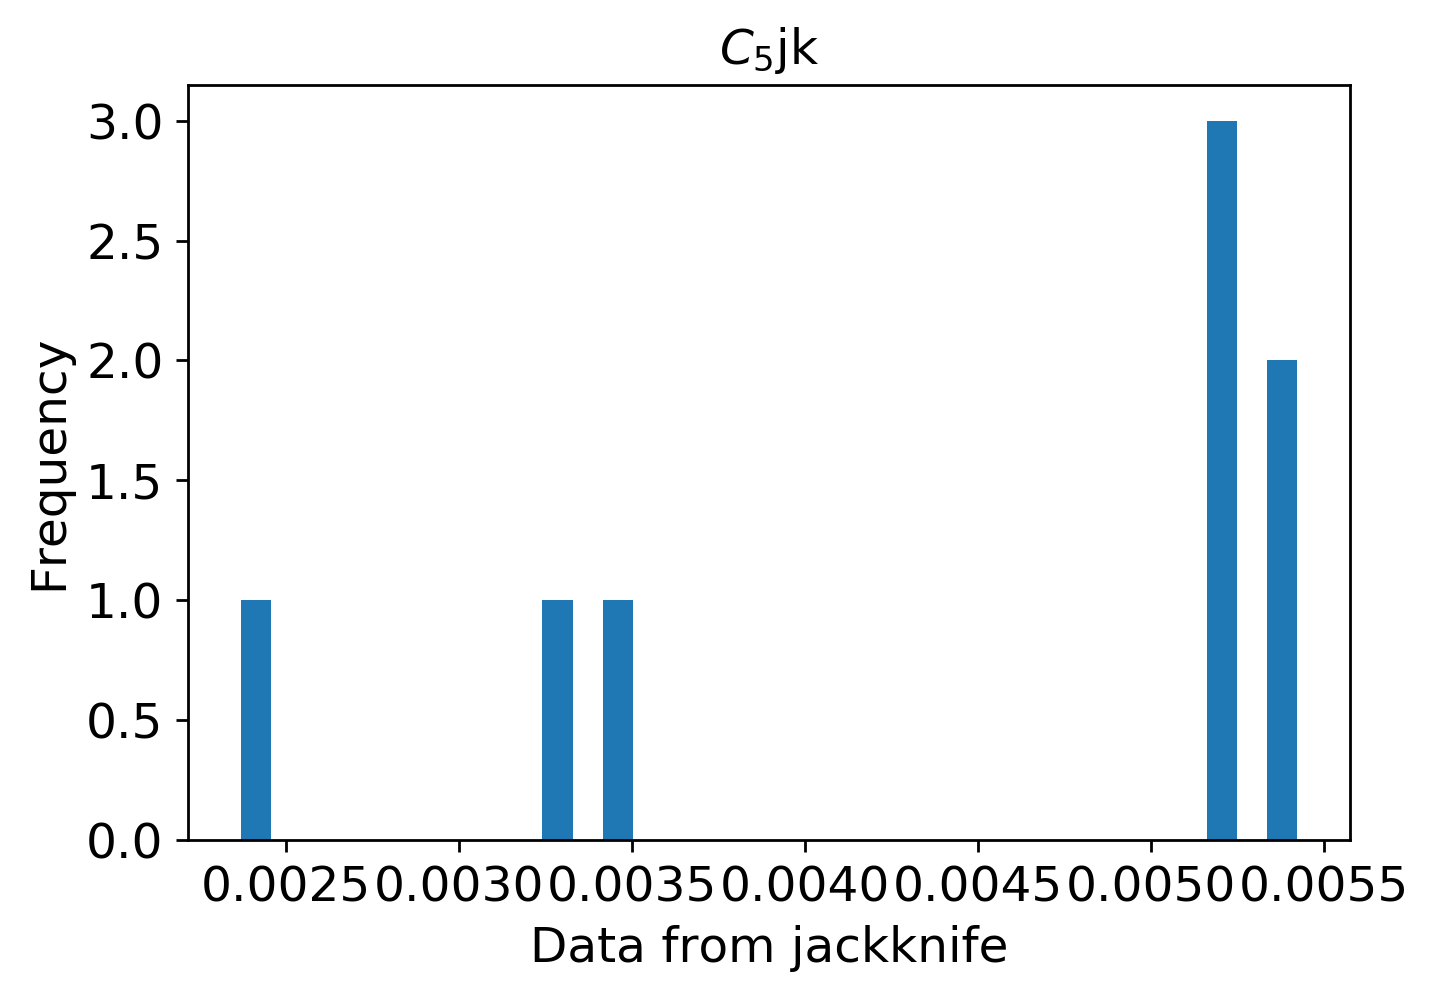

mean: 0.002642679930870725
jk_e: 0.00023530573151853005
CI 0.00046119923377631886


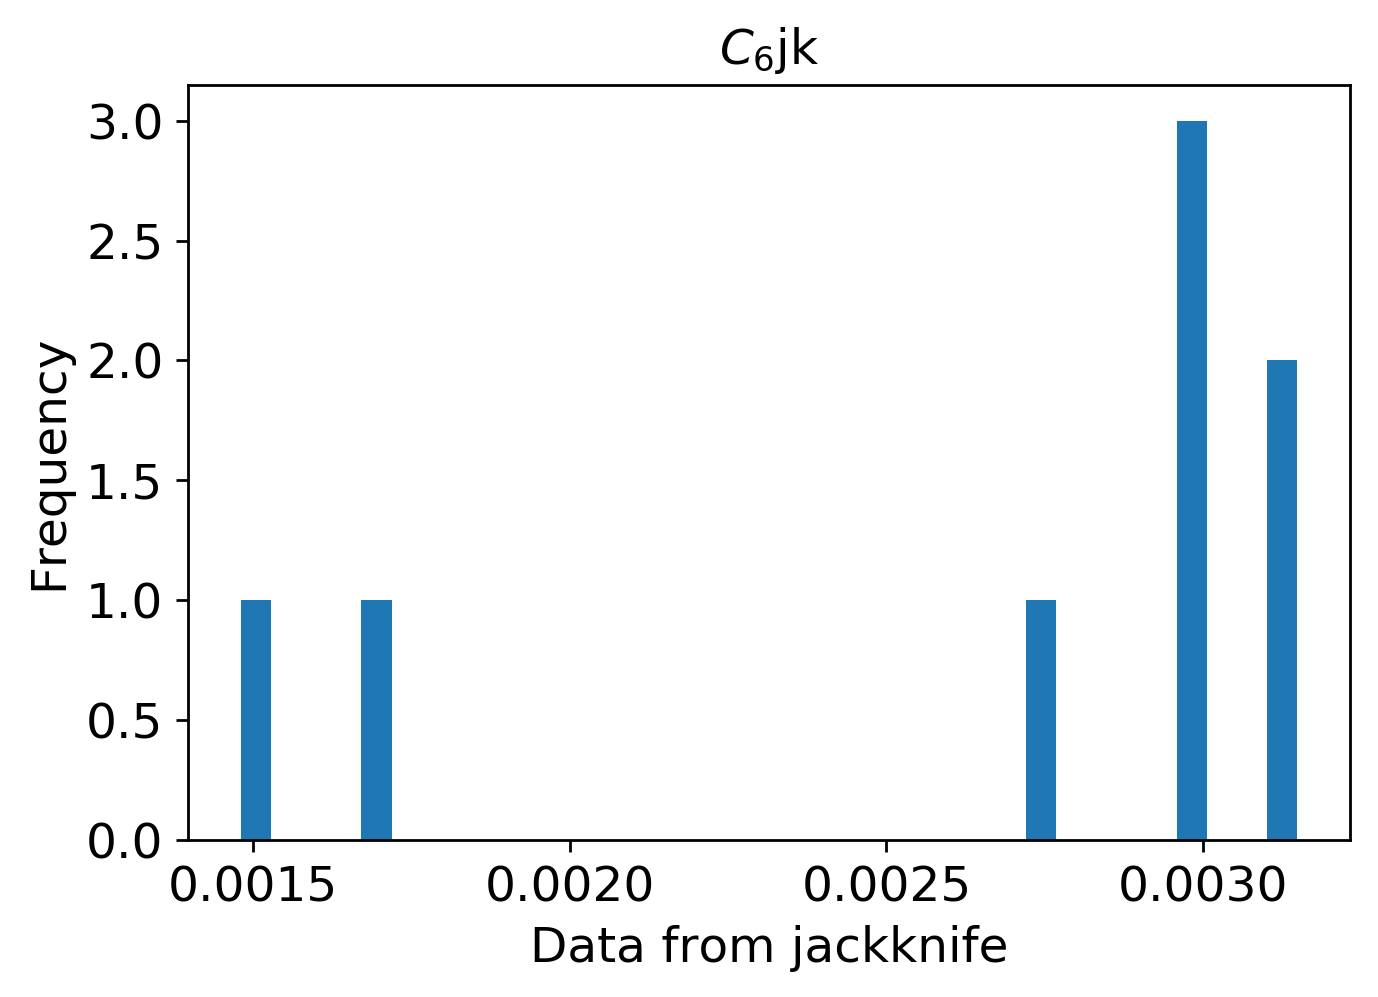

mean: 0.0025779630562525586
jk_e: 0.0003532371849901522
CI 0.0006923448825806983


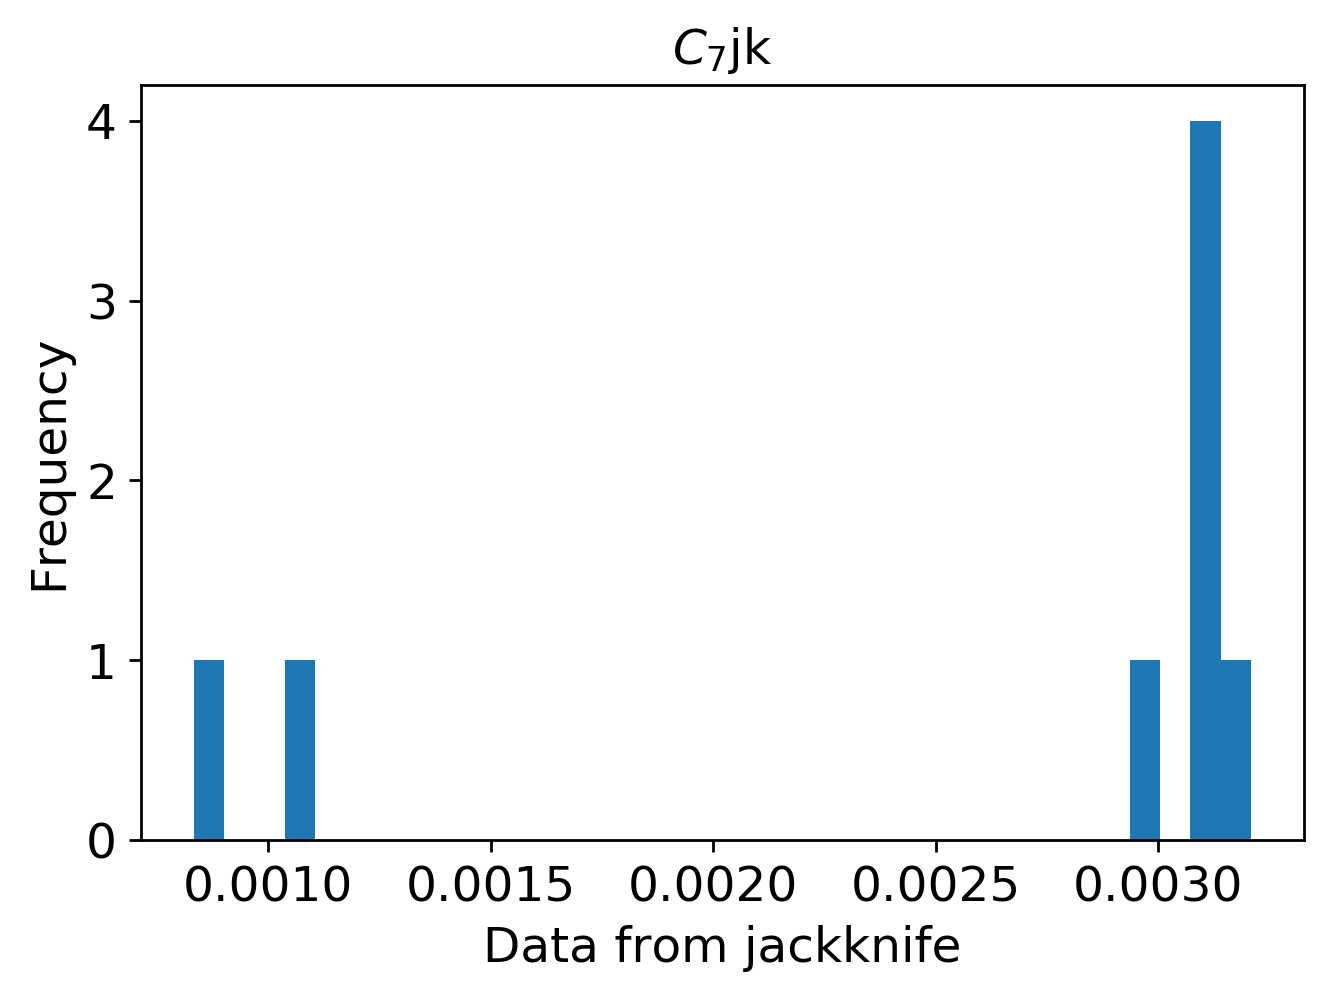

In [5]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g7_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g7_j2_roi770_jogan_5500_400grid/5000/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 7
#gclass_label = ["406 ${\mu}m$", "268 ${\mu}m$",
                #"177 ${\mu}m$", "117 ${\mu}m$"]
topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv(
    '../Journal_2/jogan_gs7_range.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_jogan_gs7.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../Journal_2/jogan_gs7_range.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="cubic", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_jogan_gs7.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk','$C_5$jk','$C_6$jk','$C_7$jk']
jk_er=[]
with open('jk_e_770jogan_g7','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        #ci_u=mean+(1.96*jk_e)
        #ci_l=mean-(1.96*jk_e)
        CI=(1.96*jk_e)
        print("jk_e:",jk_e)
        #print("CI_u", ci_u)
        #print("CI_l",ci_l)
        print("CI",CI)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.eps')
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.pdf')
        plt.show()

     distance       513       453       400       354       312       276  \
0    0.000000  0.021065  0.022898  0.017641  0.016226  0.002465  0.002237   
1  109.646182  0.015466  0.016398  0.012310  0.011210  0.001322  0.001217   
2  450.682215  0.005640  0.006018  0.004529  0.004128  0.000372  0.000340   
3  543.078703  0.010462  0.012003  0.009828  0.009243  0.001080  0.000985   
4  674.221738  0.008758  0.012232  0.011496  0.011298  0.003010  0.002508   
5  766.825235  0.003999  0.006536  0.006360  0.006313  0.002220  0.001804   
6  879.030860  0.000656  0.001052  0.001034  0.001029  0.000385  0.000312   
7  965.302169  0.002321  0.004002  0.004189  0.004239  0.002278  0.001827   

        244  
0  0.001563  
1  0.000964  
2  0.000272  
3  0.000743  
4  0.000679  
5  0.000244  
6  0.000038  
7  0.000097  
[[0.1073754  0.09826638 0.08966473 ... 0.02084474 0.02092415 0.02098211]
 [0.20584013 0.18746617 0.17013019 ... 0.07582376 0.07407775 0.0723111 ]
 [0.05859113 0.05511992 0.05181254

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


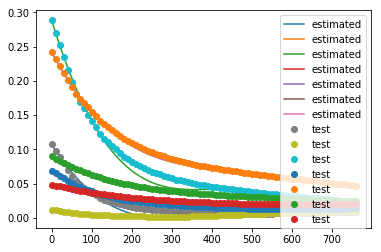

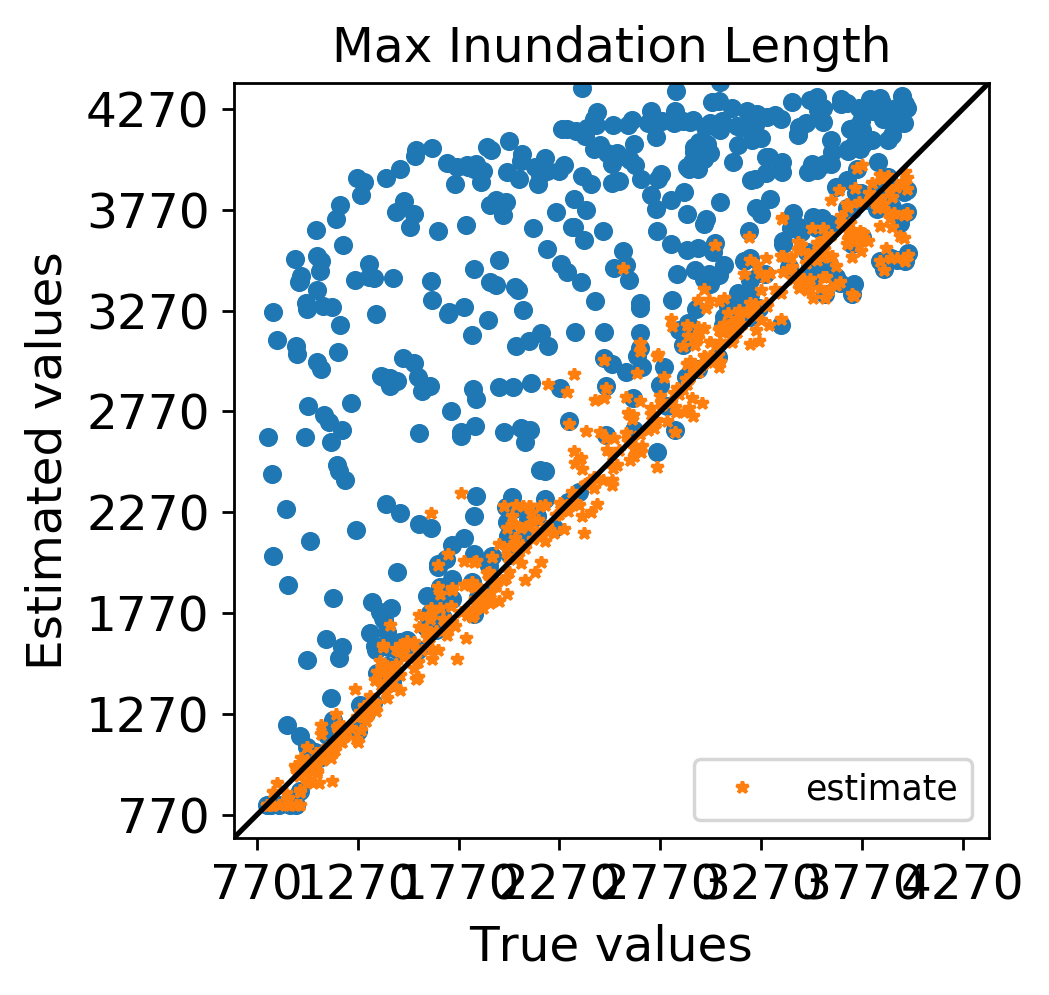

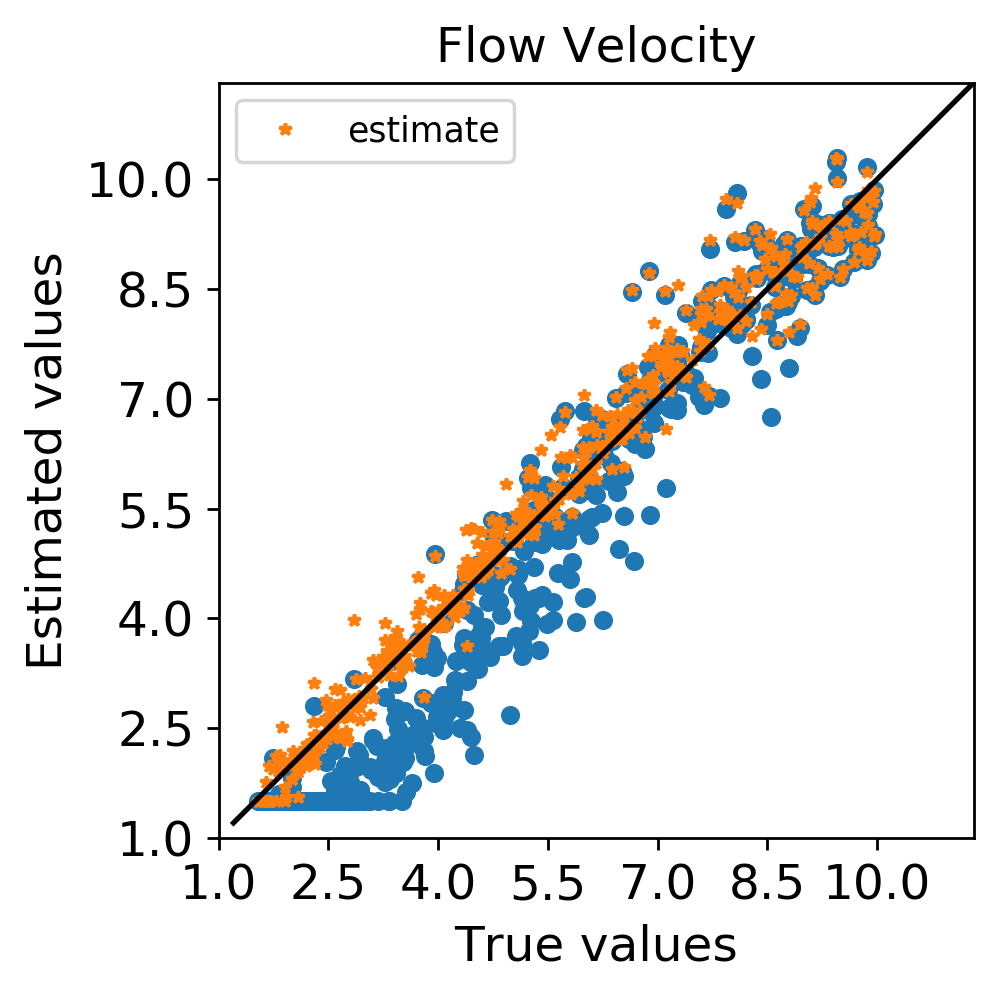

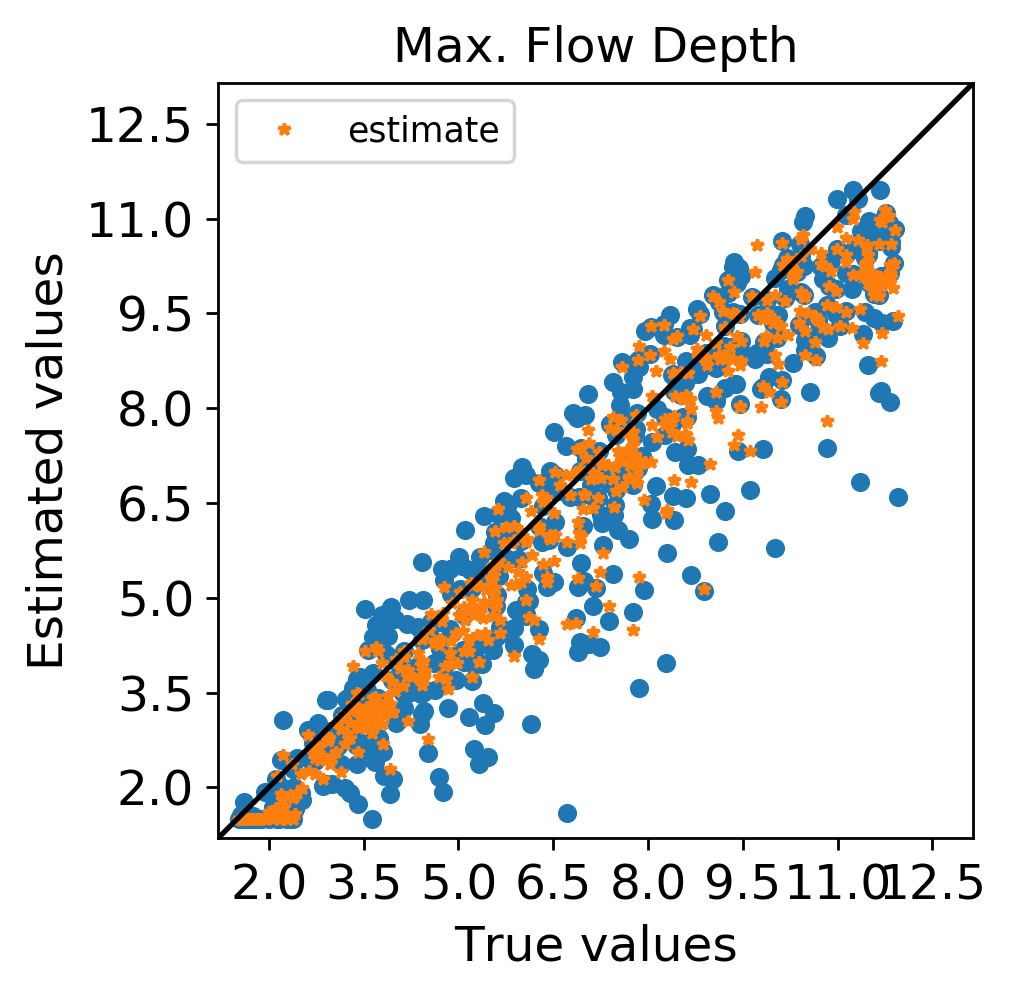

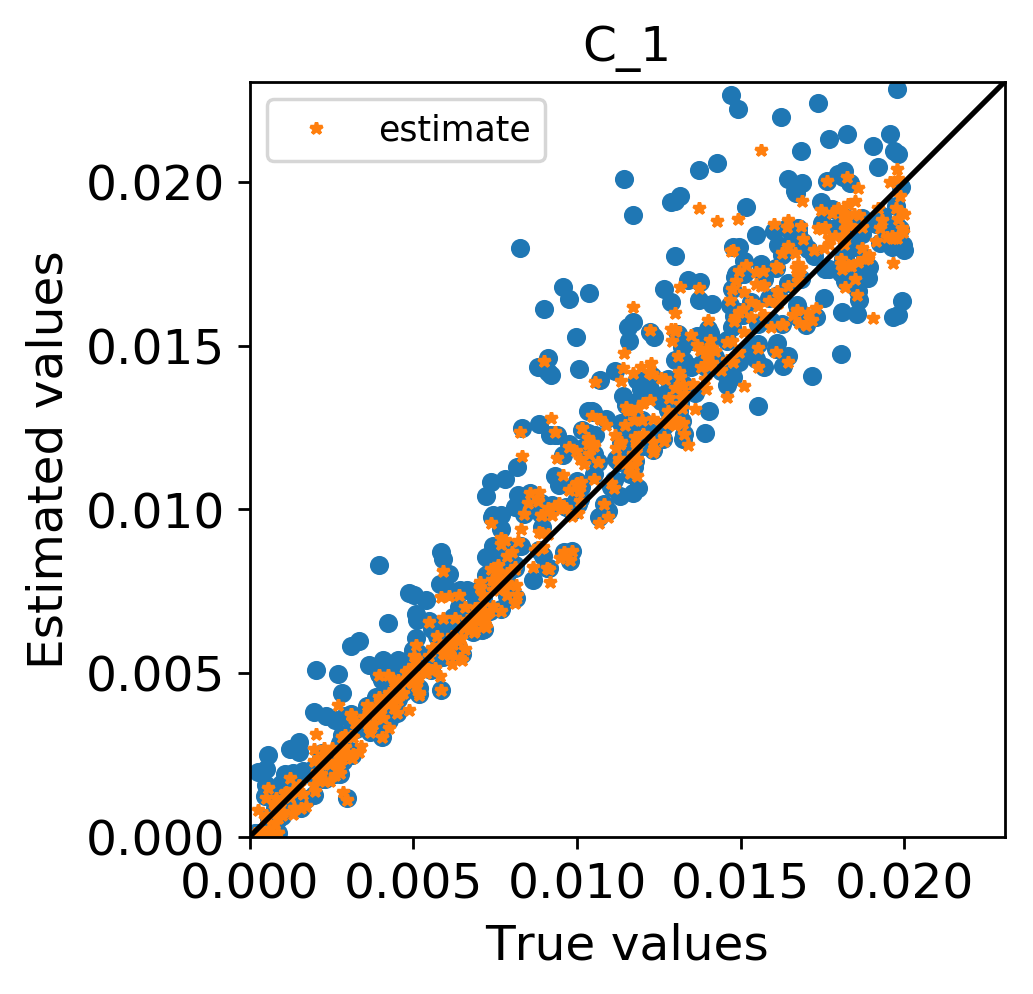

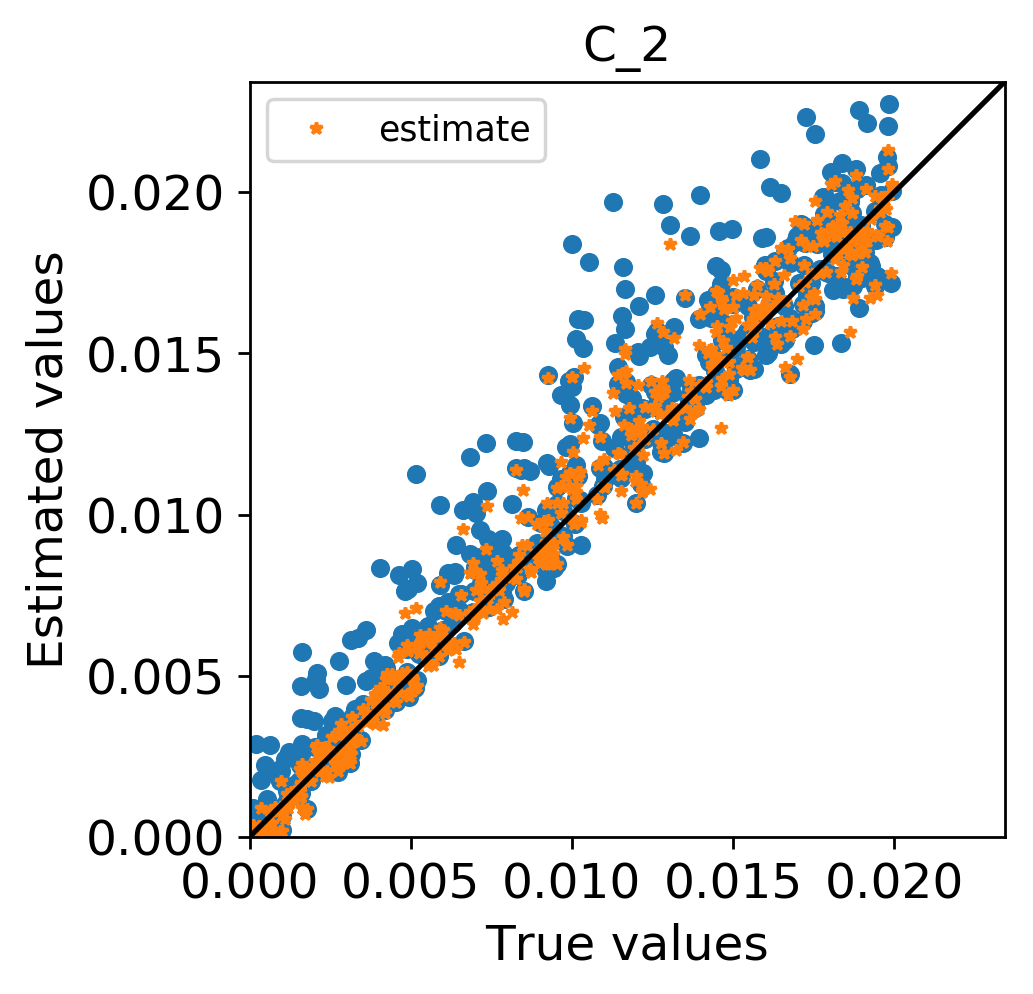

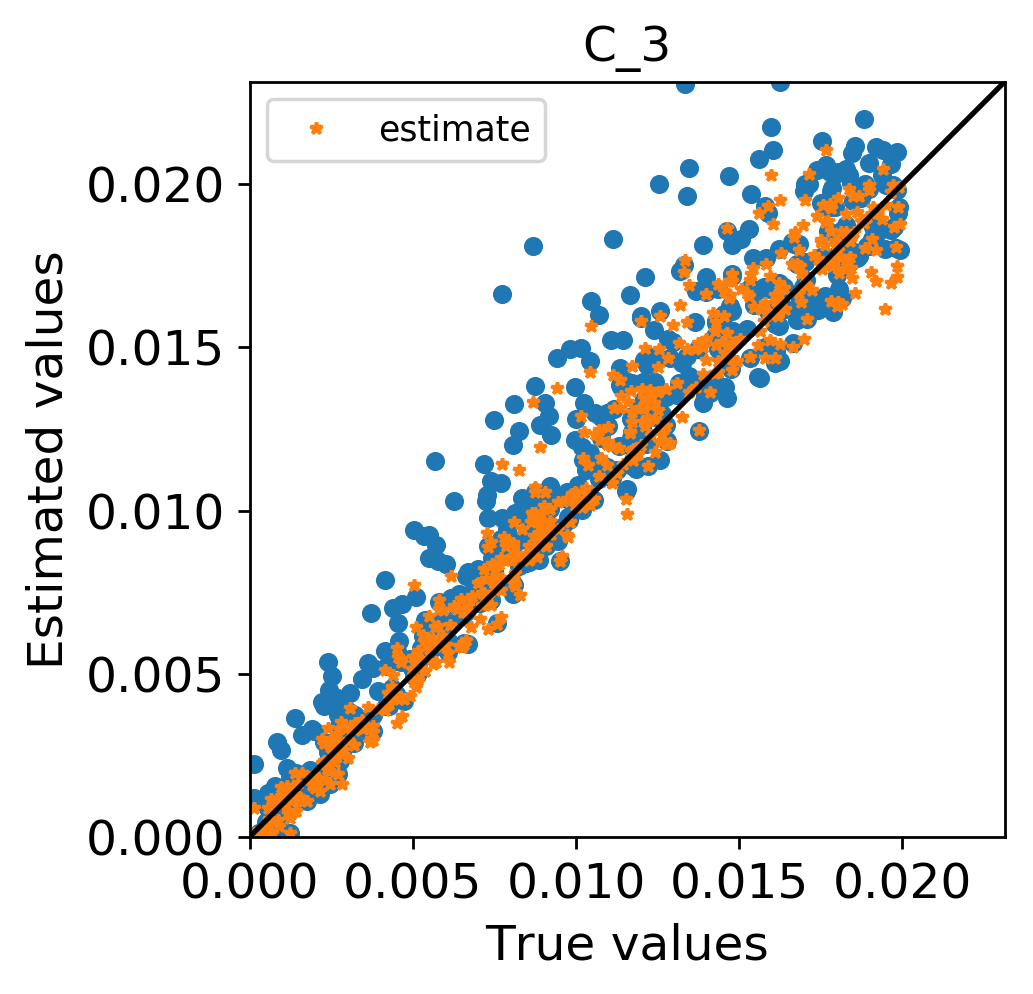

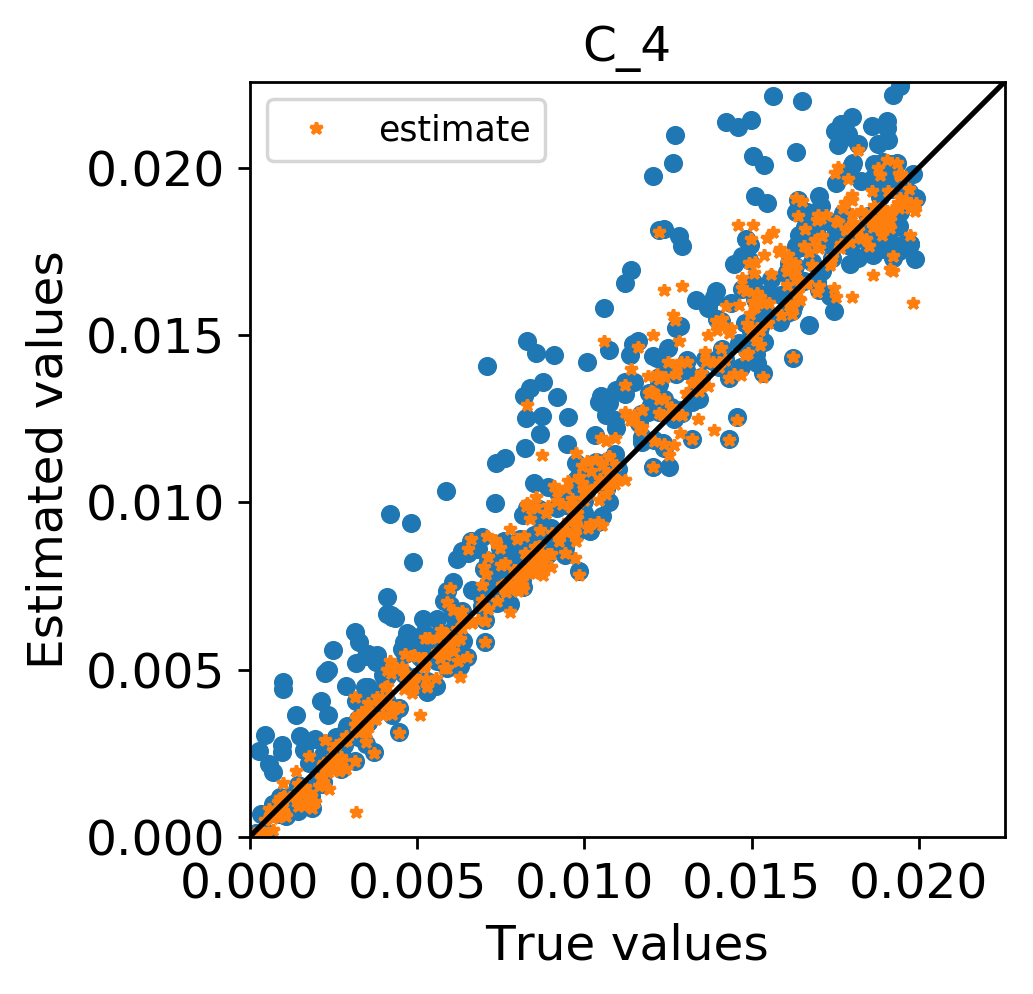

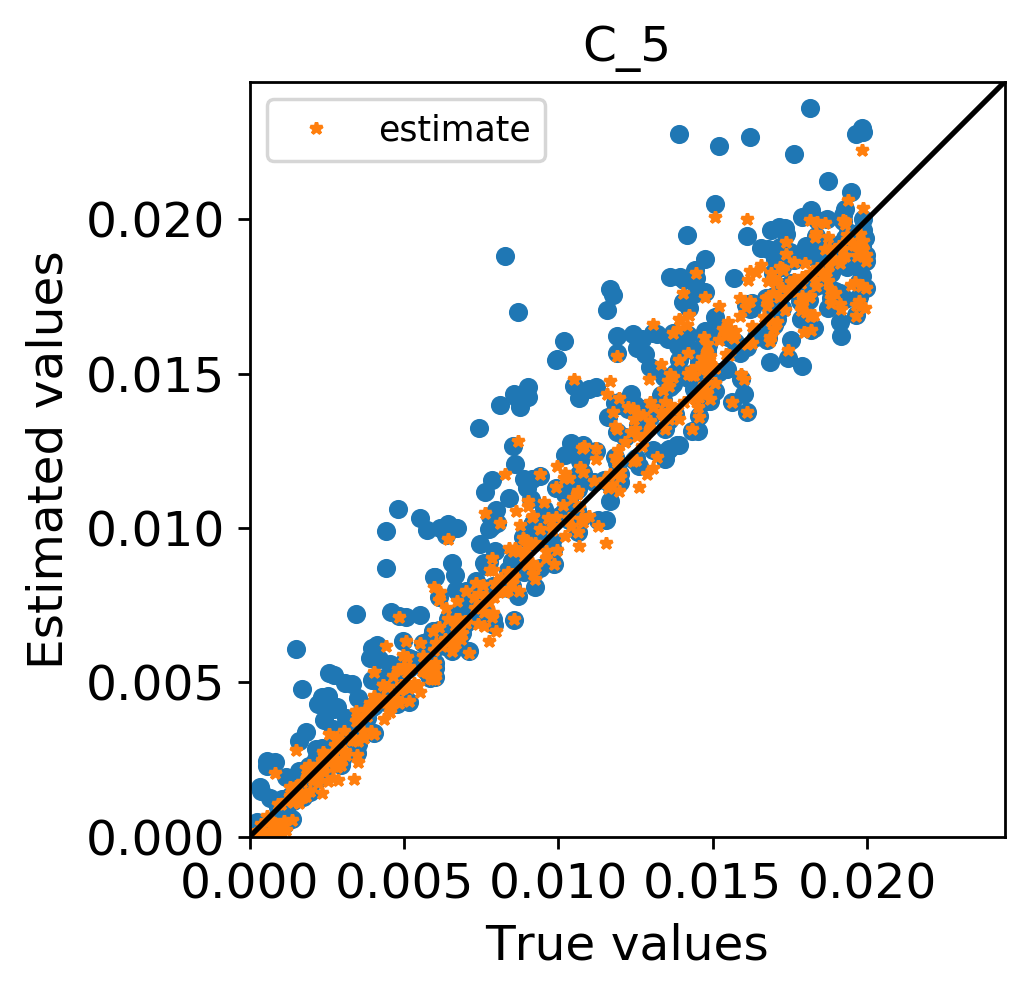

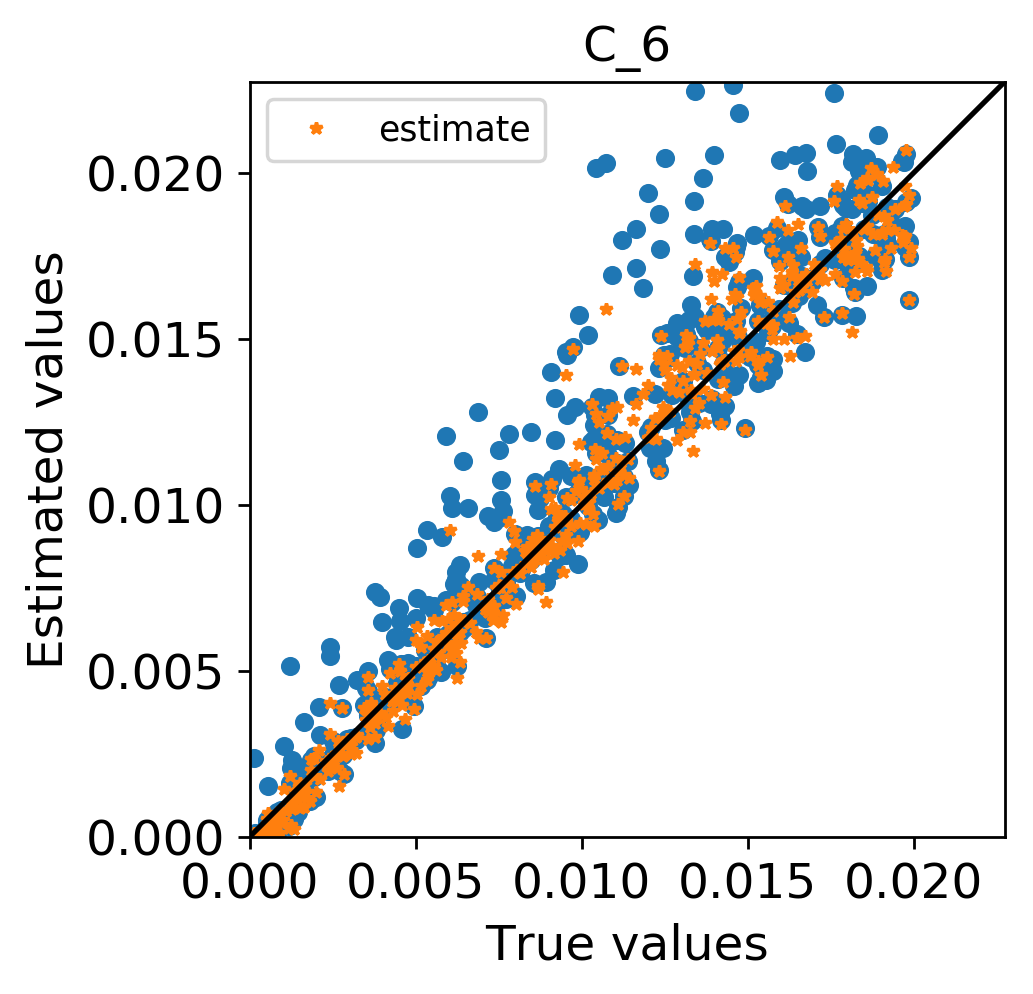

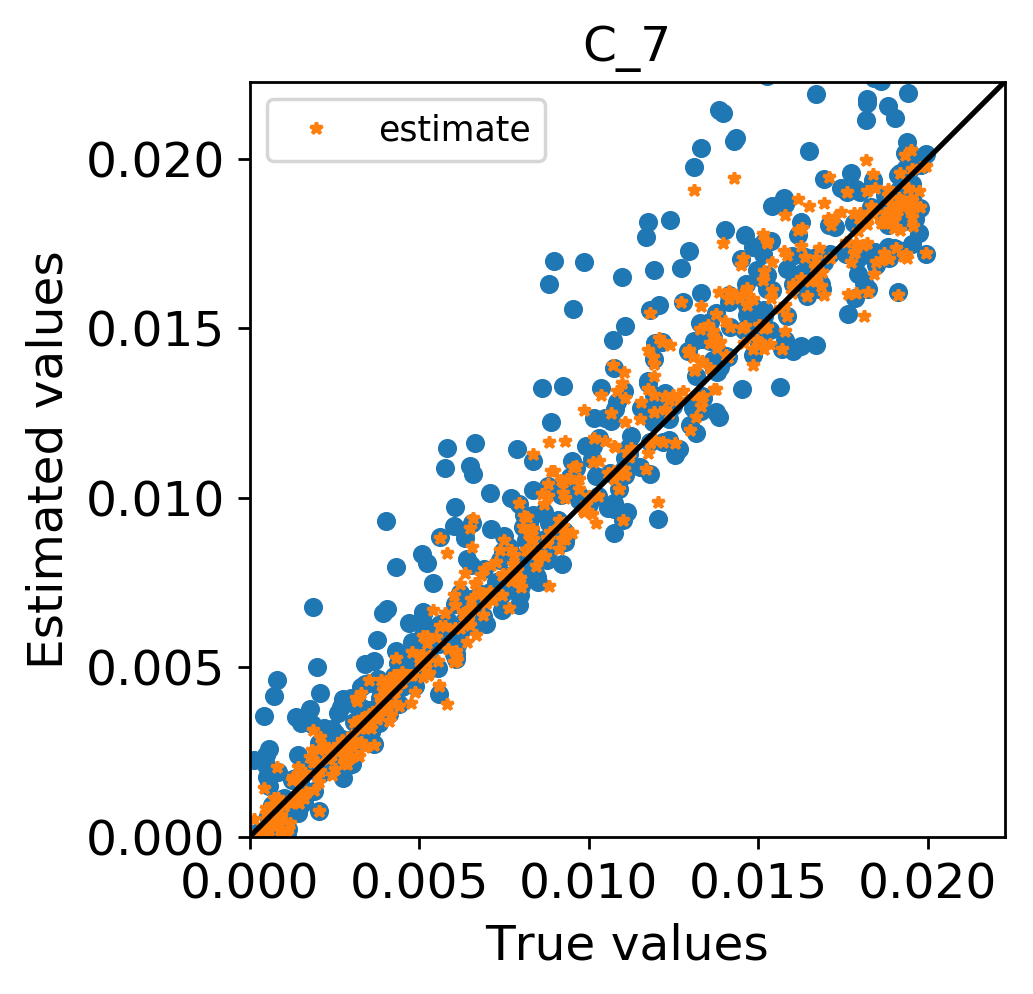

Standard Deviation sample: 763.3672949486826
Mean: 834.9095418508034
mode ModeResult(mode=array([-468.78397552]), count=array([1]))
m 648.8112796521018


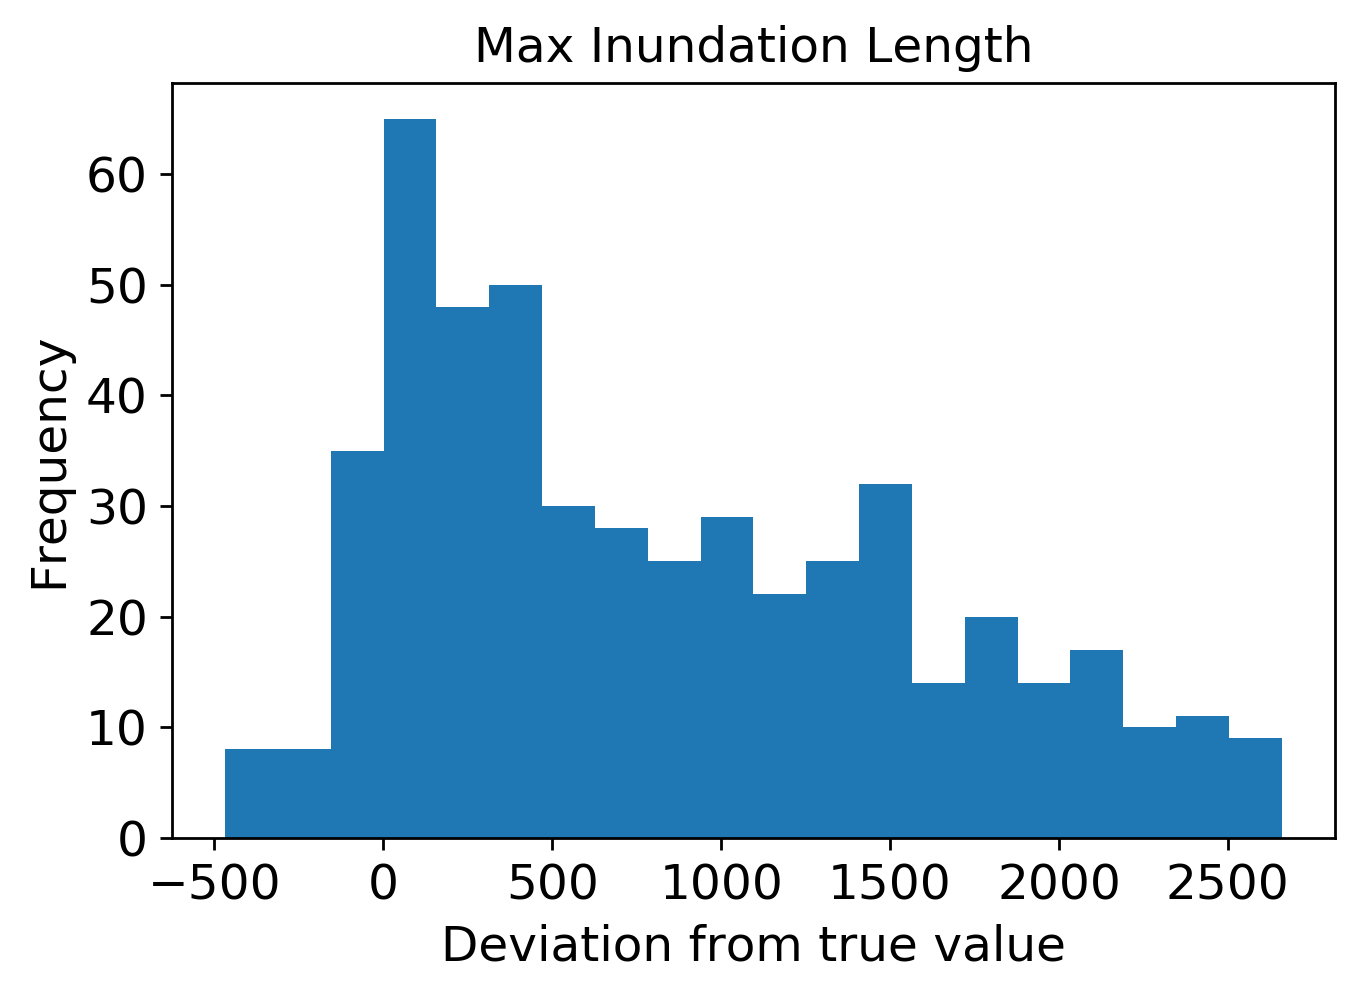

Standard Deviation sample: 0.7228012186595341
Mean: -0.44399804231359263
mode ModeResult(mode=array([-2.36133665]), count=array([1]))
m -0.40814273133833656


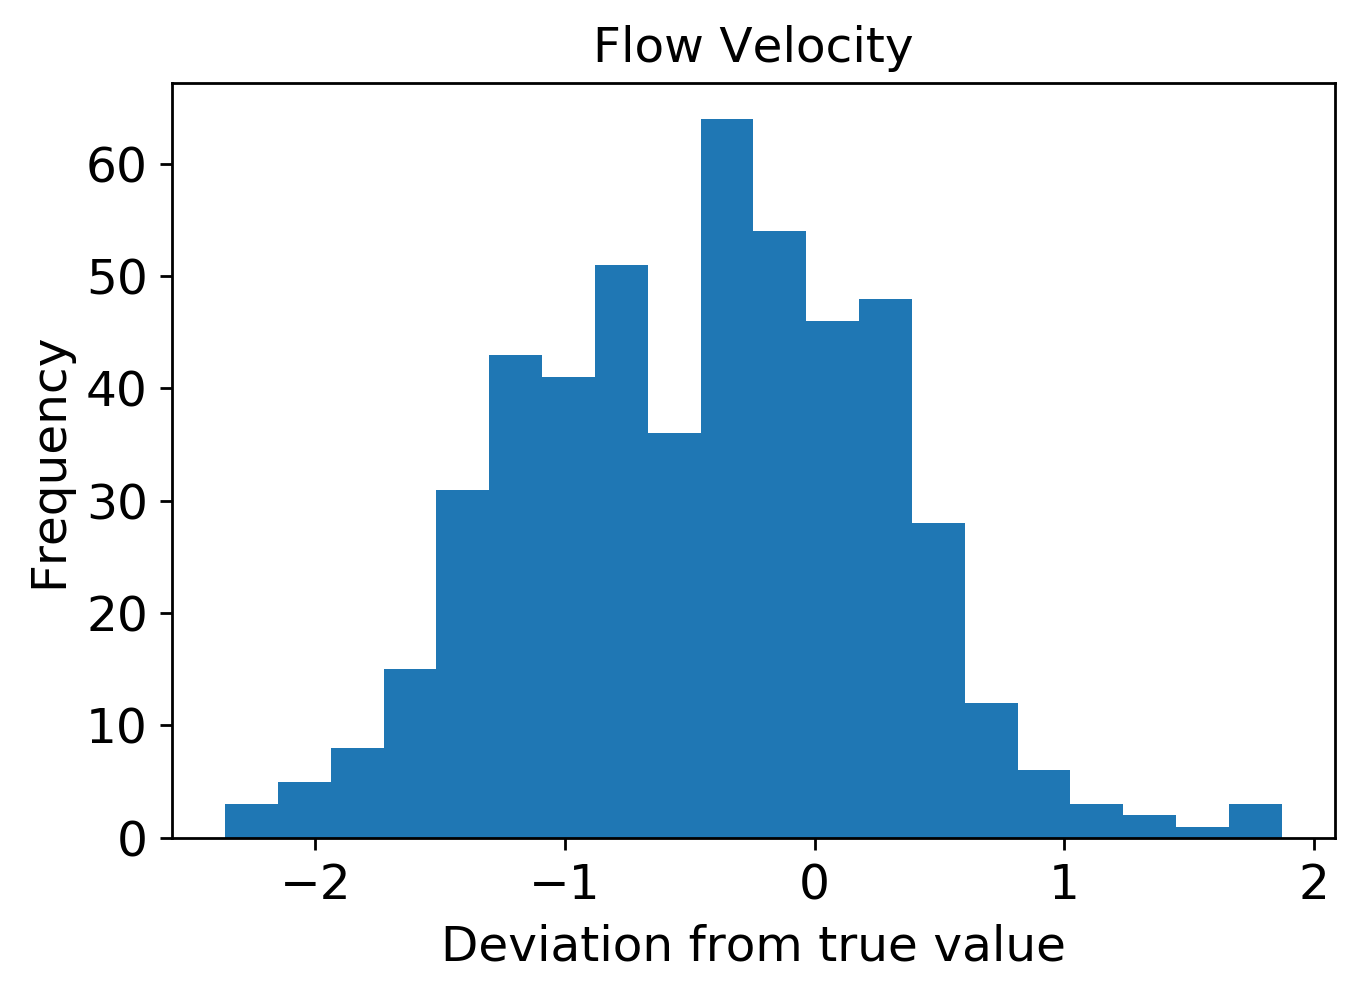

Standard Deviation sample: 1.0658821317175815
Mean: -0.6537907495186135
mode ModeResult(mode=array([-5.35284424]), count=array([1]))
m -0.5225158499375366


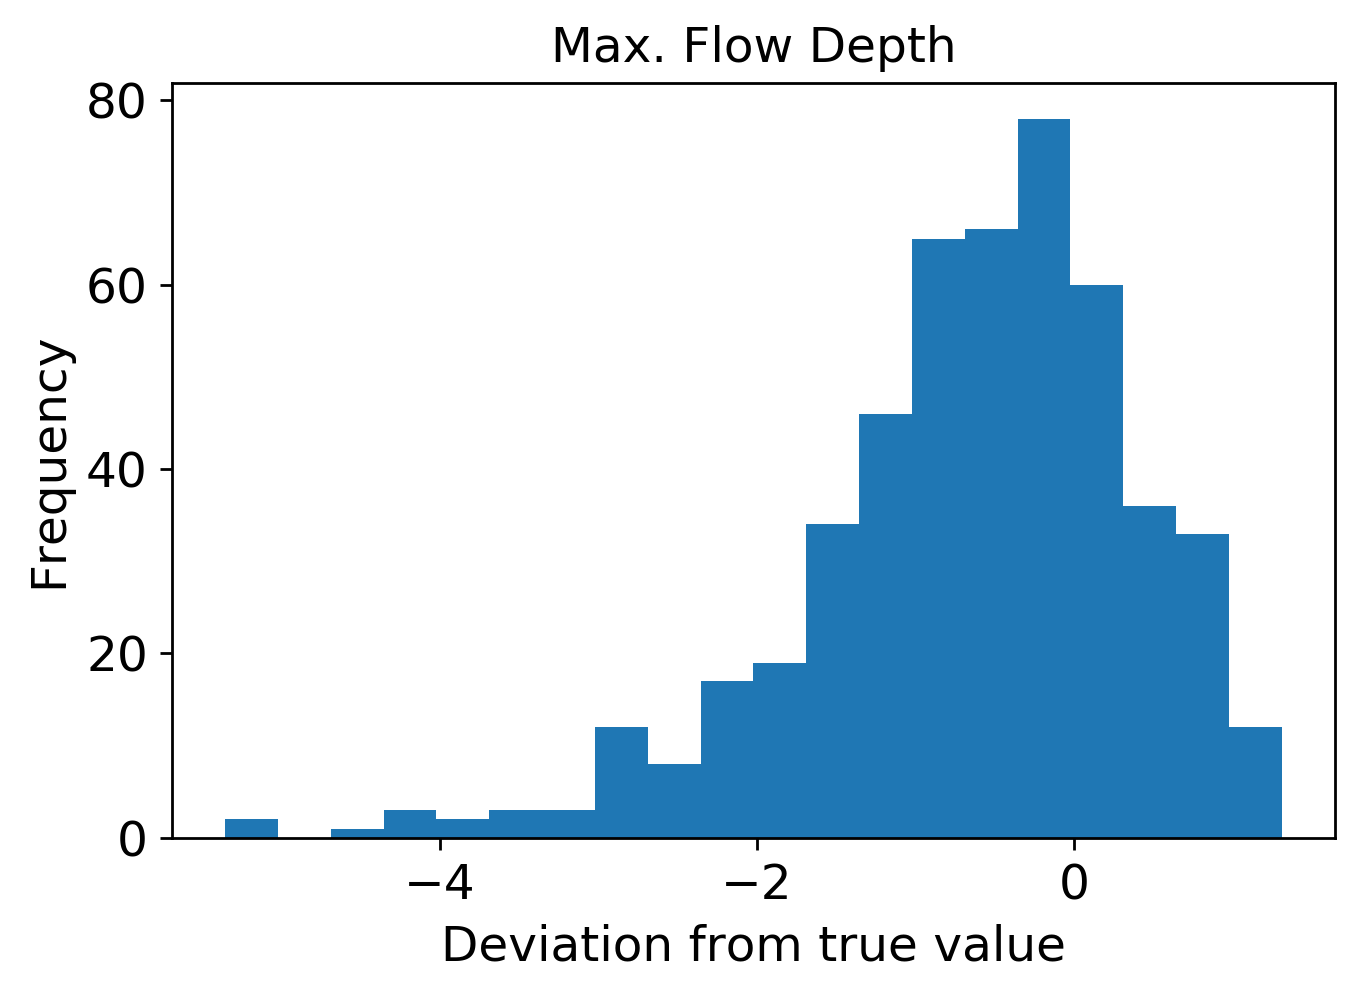

Standard Deviation sample: 0.001852616288906947
Mean: 0.0008186548025894251
mode ModeResult(mode=array([-0.00385878]), count=array([1]))
m 0.0004193522811501019


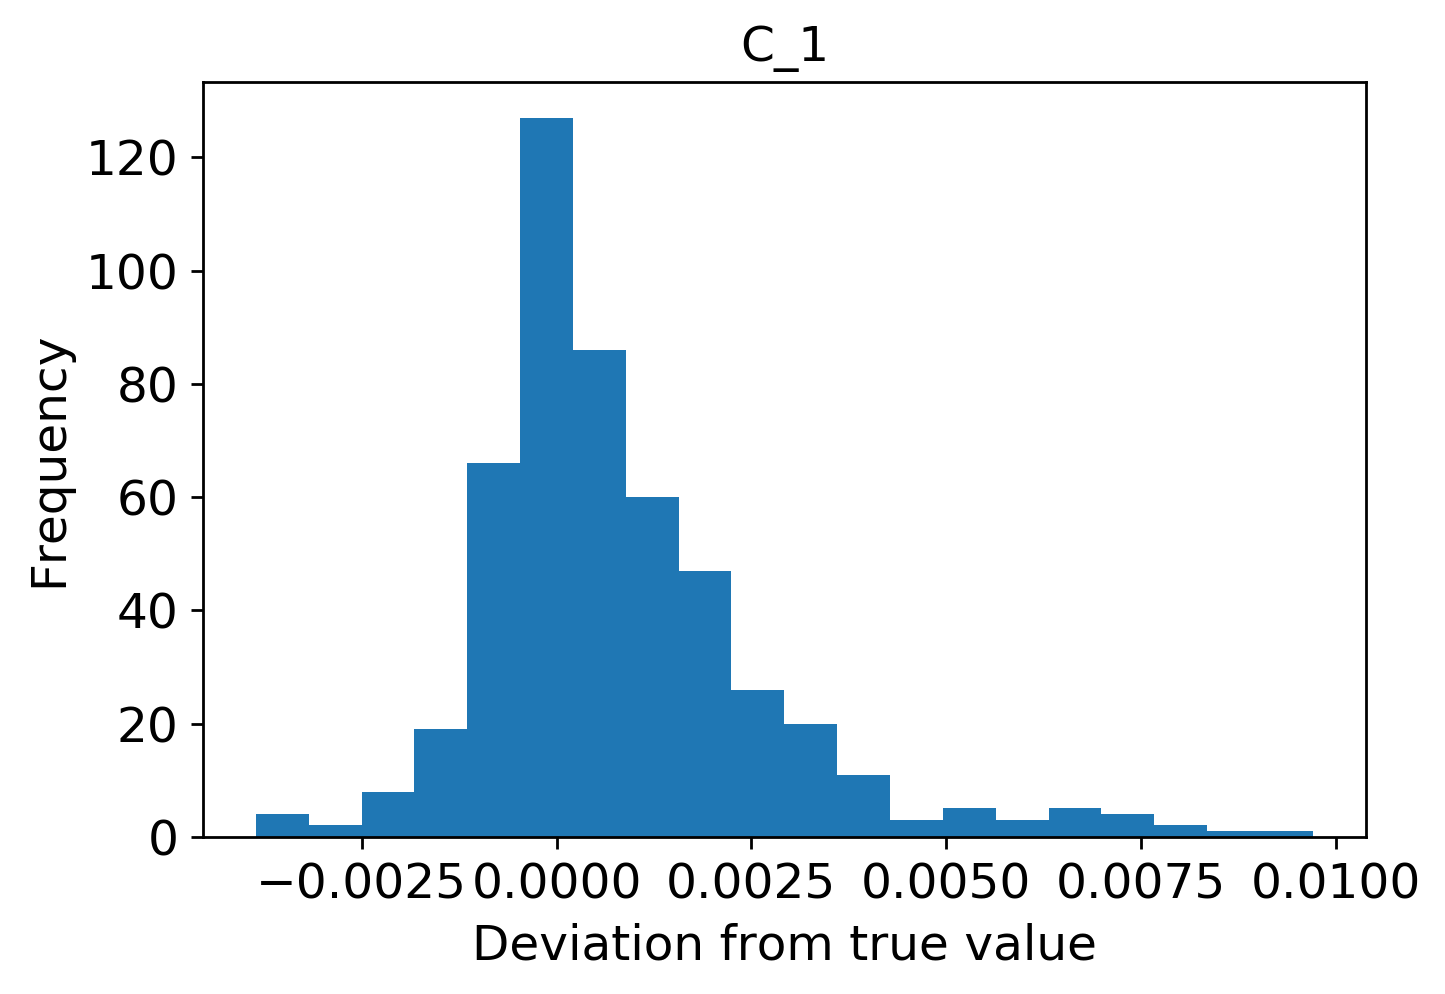

Standard Deviation sample: 0.001702871825033922
Mean: 0.0009229185605823269
mode ModeResult(mode=array([-0.00302884]), count=array([1]))
m 0.0005644540512229224


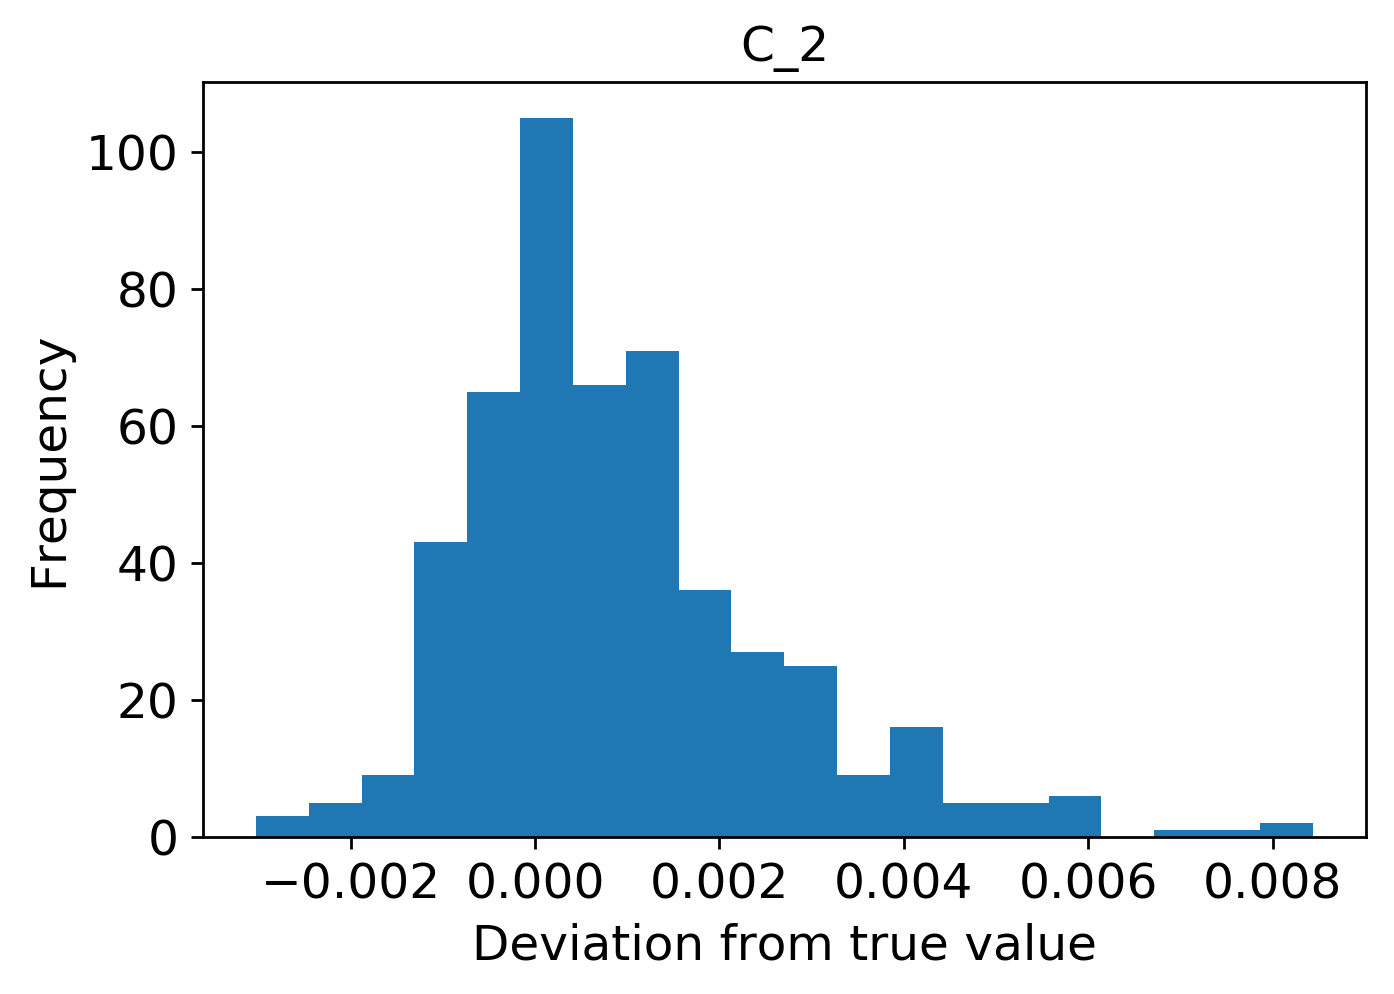

Standard Deviation sample: 0.0017675229309225301
Mean: 0.0011096416464509958
mode ModeResult(mode=array([-0.00194545]), count=array([1]))
m 0.0007218648709703119


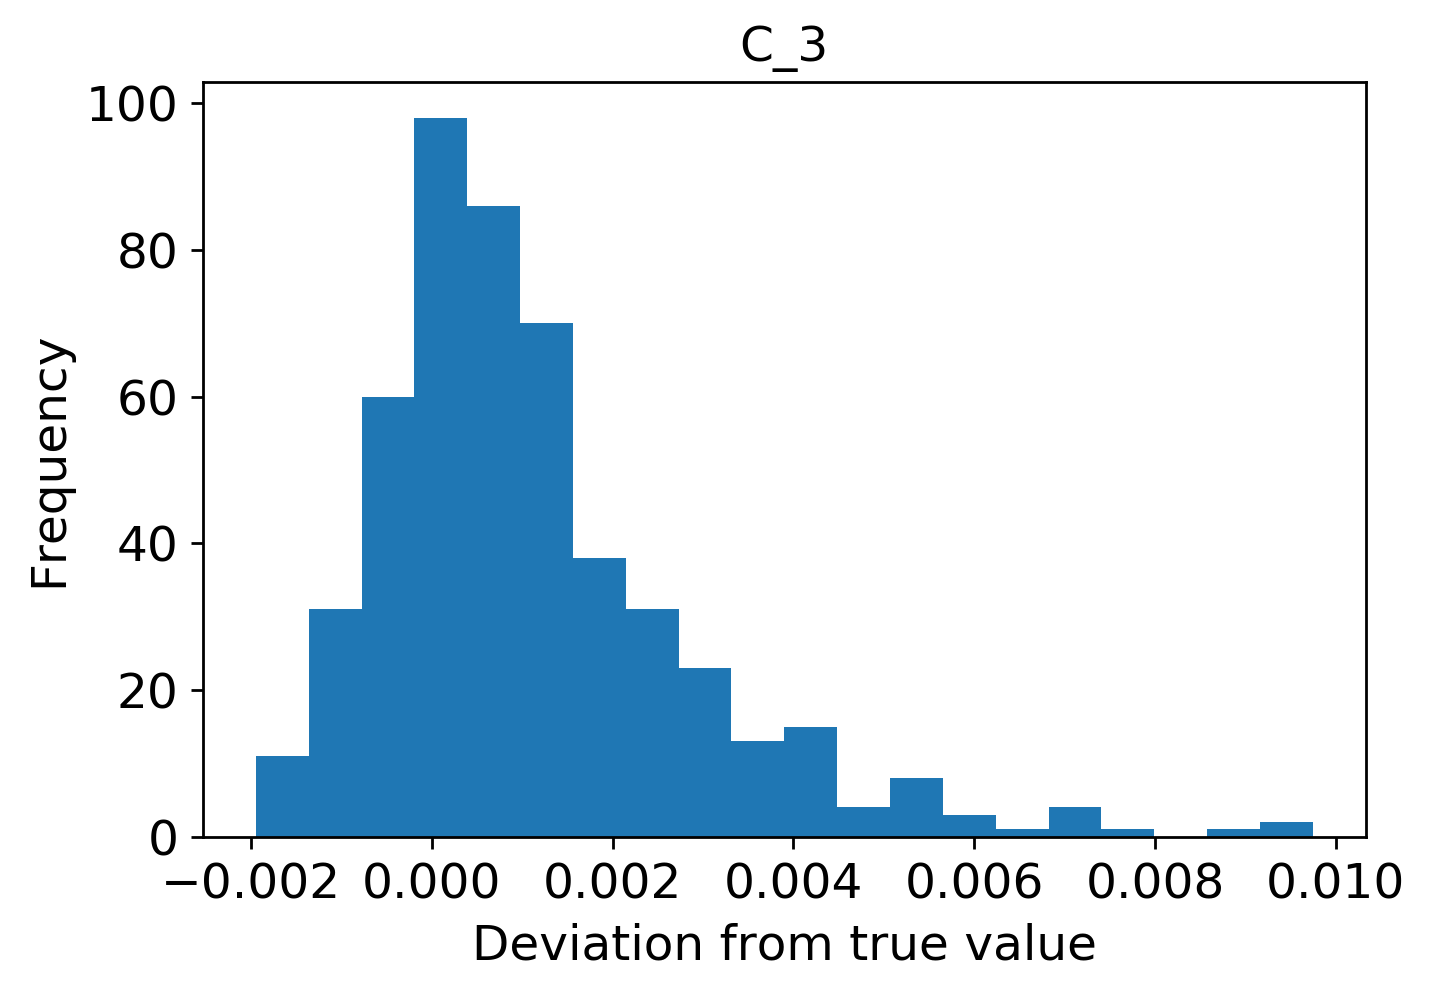

Standard Deviation sample: 0.0017371833258016404
Mean: 0.0009198622618914708
mode ModeResult(mode=array([-0.0026152]), count=array([1]))
m 0.0004634832970928839


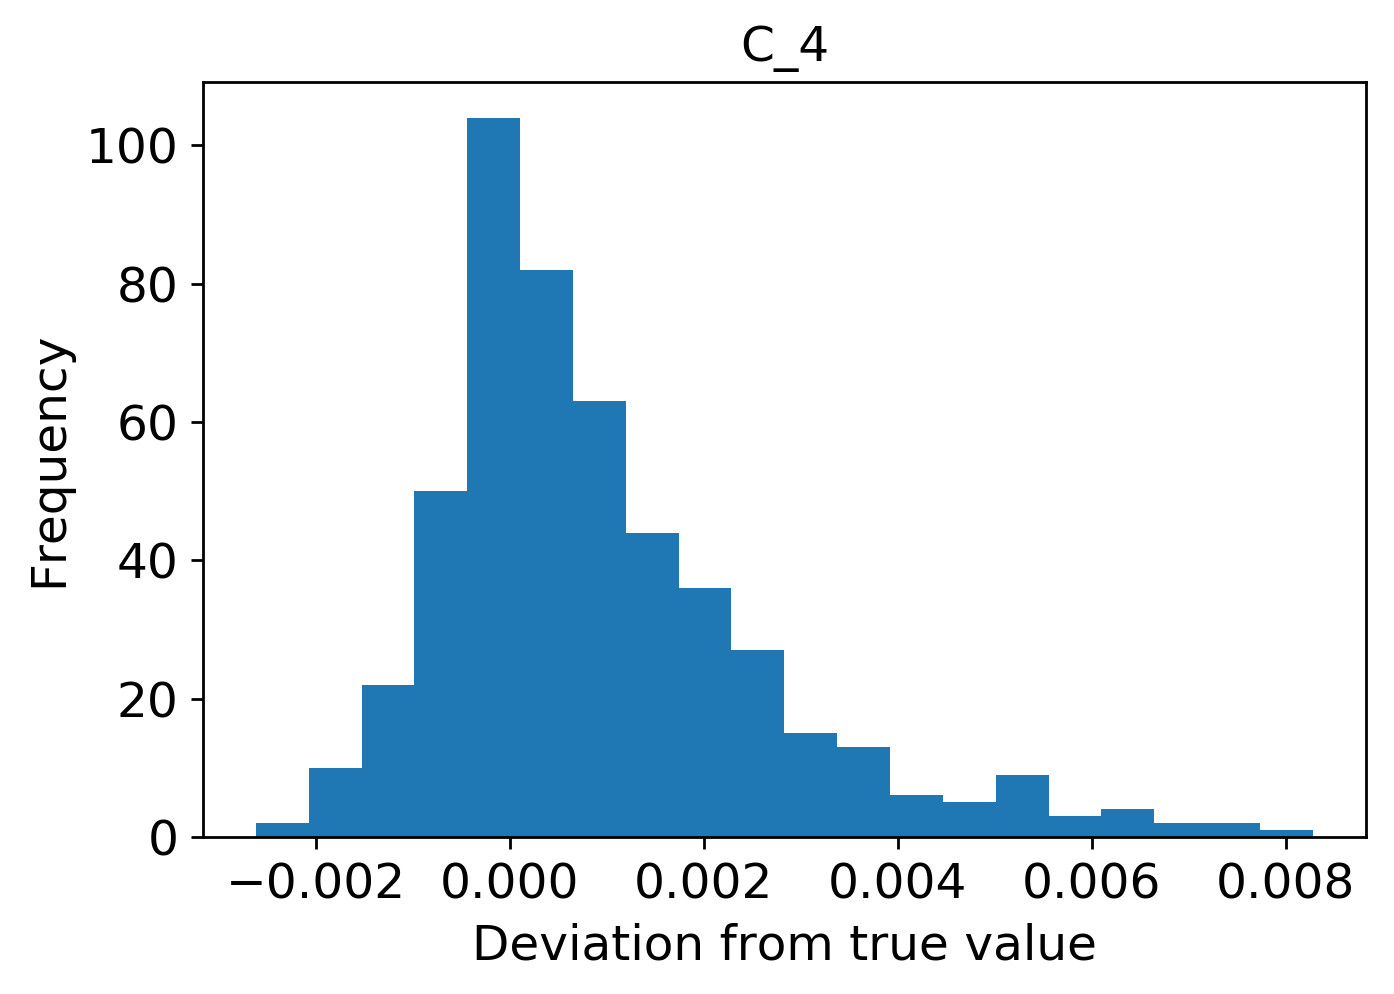

Standard Deviation sample: 0.0018214459444335115
Mean: 0.0008898165199727065
mode ModeResult(mode=array([-0.00294544]), count=array([1]))
m 0.0004998073575112542


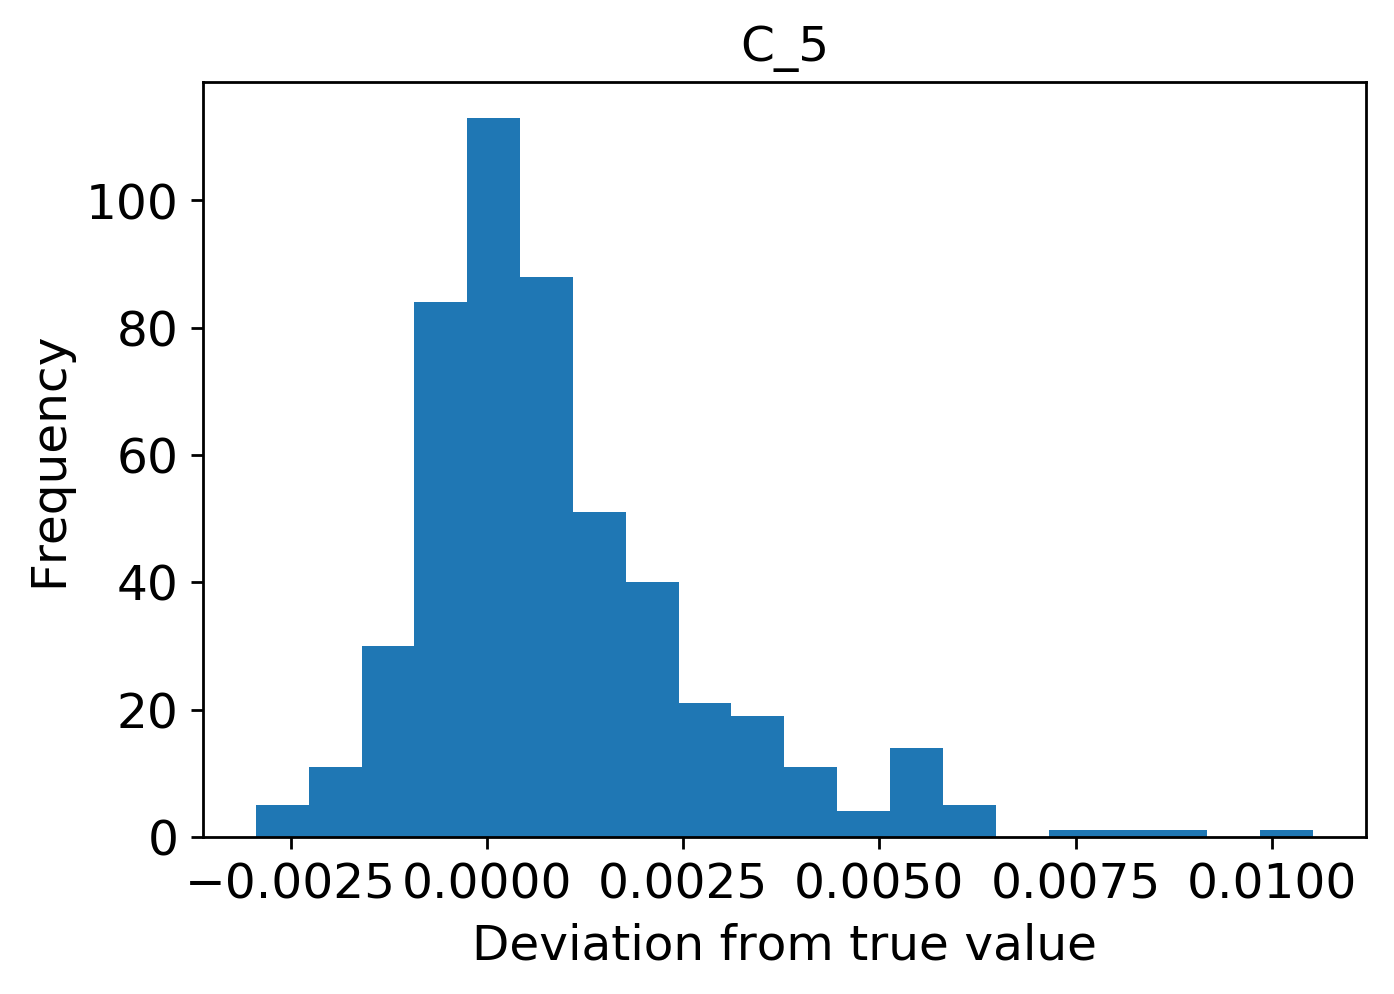

Standard Deviation sample: 0.0019507771187527929
Mean: 0.0008729328685706303
mode ModeResult(mode=array([-0.00367353]), count=array([1]))
m 0.00032996091423562115


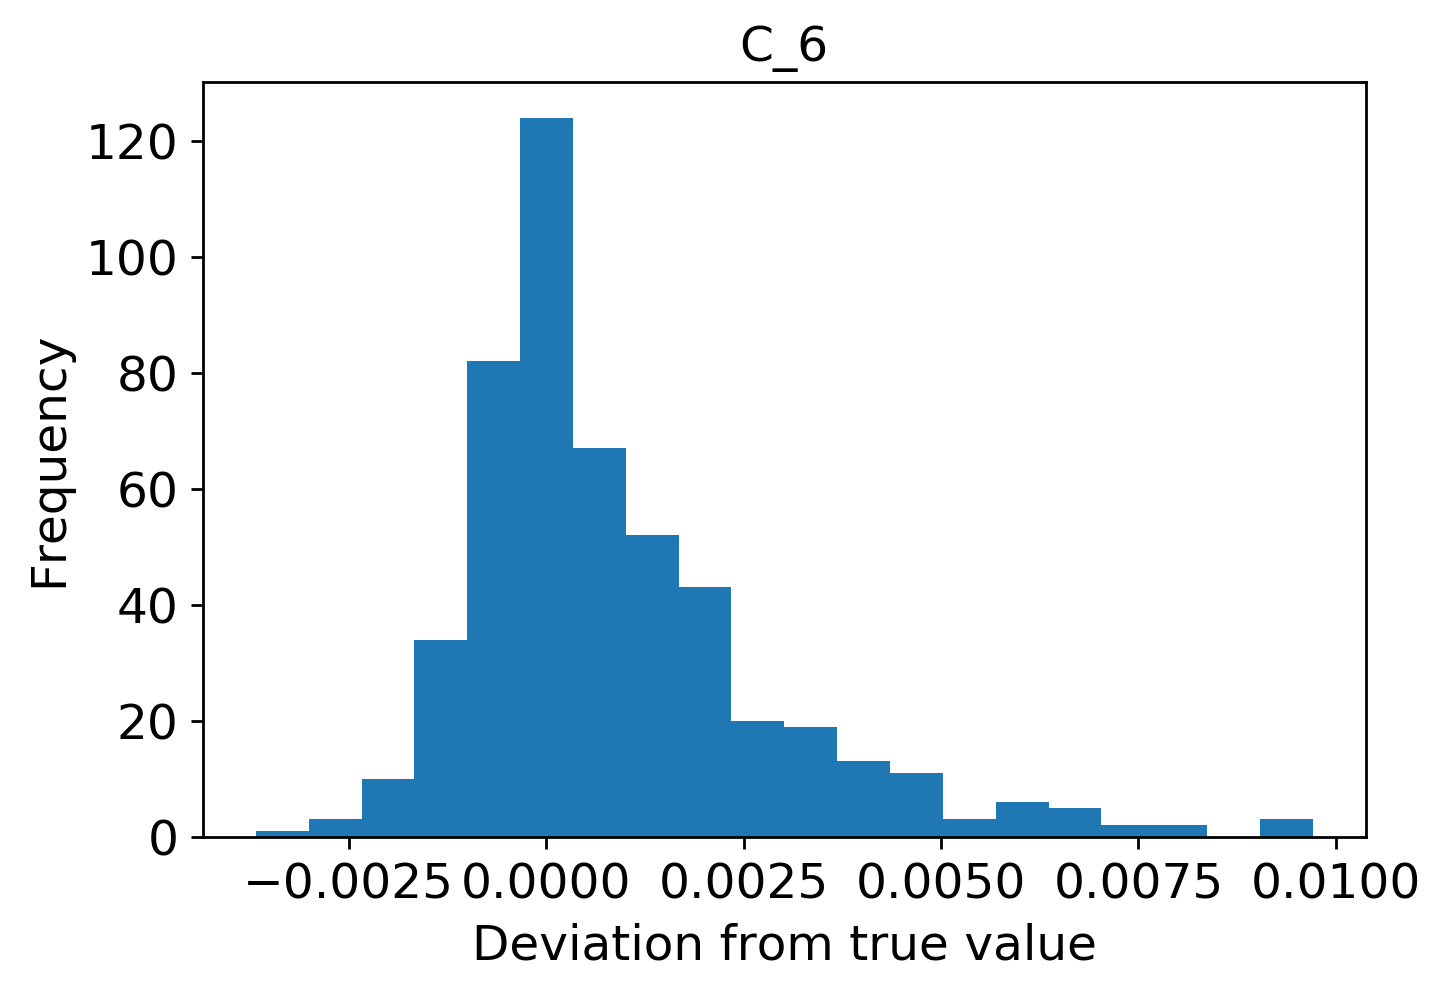

Standard Deviation sample: 0.0018340131425153533
Mean: 0.0007881506573195257
mode ModeResult(mode=array([-0.00303067]), count=array([1]))
m 0.00030203048508980557


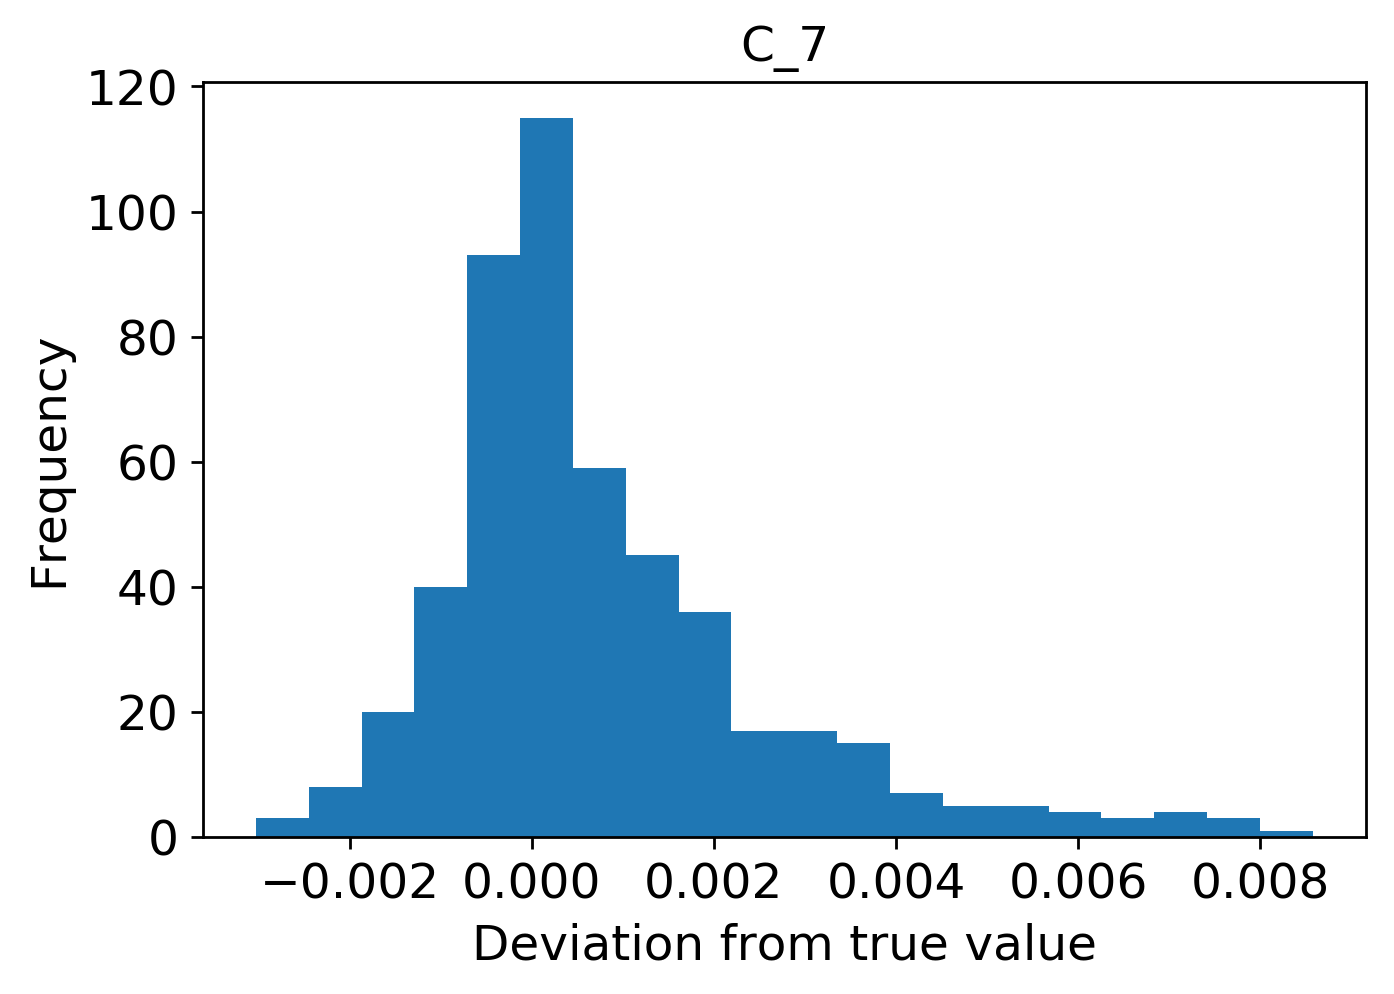

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb
from scipy import stats

import ipdb
#ipdb.set_trace()

datadir = '/home/rimali2009/Journal_2/data_g7_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g7_j2_roi770_jogan_5500_400grid/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

# Load test datasets

X_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')


# Normalize the test datasets
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
X_test_norm =  (X_test - min_x) / (max_x - min_x)


gclass = 7
gclass_name= ['513','453','400','354','312','276','244']
gclass_label = ["513${\mu}m$","453 ${\mu}m$", "400 ${\mu}m$","354${\mu}m$", "312${\mu}m$","276${\mu}m$","244${\mu}m$"]



topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

# Load outcrop data
outcrop = pd.read_csv('../Journal_2/jogan_gs7_range.csv')
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
outcrop_num = len(outcrop['distance'])
print(outcrop)

#Preparation under interpolation
thick_interp_at_outcrop = np.zeros([X_test.shape[0],outcrop_num*gclass])
thick_interp = np.zeros([X_test.shape[0],coord_num*gclass])#Interpolated sample thickness data
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #Index number of sampling point in inverse analysis system
x = np.arange(0,coord_num*topodx,topodx)

# Interpolation of test datasets at the outcrop locations
for i in range(X_test.shape[0]):
    for j in range(gclass):
        f = interp1d(x,X_test_norm[i,j * coord_num : (j+1) * coord_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp_at_outcrop[i,outcrop_num*j:outcrop_num*(j+1)] = f(outcrop['distance']) #Supplemented data

    # Interpolation of test datasets at the grids of the forward model
    for j in range(gclass):
        f = interp1d(outcrop['distance'],thick_interp_at_outcrop[i,j * outcrop_num : (j+1) * outcrop_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp[i,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data
    


#Normalize data
thick_interp[thick_interp < 0] = 0
print(thick_interp)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
np.savetxt('outcrop_location_interp.txt',test_result_outcrop, delimiter=',')
test_result=np.loadtxt('outcrop_location_interp.txt', delimiter=',')
test_result_normal = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
resi=test_result-y_test
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5','C_6','C_7']
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
xymin=[770,1.5,1.5,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005,0.005,0.005]
stepmin=[770,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025,0.025,0.025]
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)], label='estimated')
for j in range(gclass):
    plt.plot(x,X_test_norm[0,j * coord_num : (j+1) * coord_num],'o',label='test')
    #plt.plot(outcrop['distance'], thick_interp_at_outcrop[0,outcrop_num*j:outcrop_num*(j+1)],'o',label='test')
plt.plot()
plt.legend()


for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(y_test[:,i],test_result[:,i],"o", markersize=4.5)
    plt.plot(y_test[:,i],test_result_normal[:,i],"*",label='estimate',markersize=3.5)
    x=y_test[:,i]
    y=test_result_normal[:,i]
    y2= test_result_normal[:, i]
    max_value = np.max([x, y, y2])
    min_value = np.min([x, y, y2])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('True values',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
    plt.legend()
    plt.axes().set_aspect('equal')
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    #plt.plot(x_lim, y_lim, color = 'k')
    plt.tick_params(labelsize=14,colors='k')
    plt.savefig(resdir+titlelabel[i] + 'outcrop_locationrev' + '.pdf')
    plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('mode',stats.mode(resi[:,i]))
    print('m',np.median(resi[:,i]))
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.pdf')
    plt.show()